# Imports

In [7]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 150 # 200 e.g. is really fine, but slower

import calendar
from datetime import datetime
from calendar import monthrange
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from gspread_formatting.dataframe import format_with_dataframe
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# gs-to-py-api@data-and-analitics-exel.iam.gserviceaccount.com
gc = gspread.service_account()

import snowflake.connector
import json
import os

snowflake_credentials_load_path = '~/credentials/snowflake_credentials.json'

# Expanding the user's home directory symbol (~)
full_path = os.path.expanduser(snowflake_credentials_load_path)

with open(full_path, 'r') as file:
    snowflake_credentials = json.load(file)
connection = snowflake.connector.connect(
    user = snowflake_credentials['user'],
    password = snowflake_credentials['password'],
    account = snowflake_credentials['account'],
    database = snowflake_credentials['database'],
    role = snowflake_credentials['role']
    )
cursor = connection.cursor()

bonusCrabXL= [
    '5gringos',
    'rabona',
    'sportaza',
    'librabet',
    'neon54',
    'slotspalace',
    '7signs',
    'buran', # 'burancasino',
    'burancasino', # 'burancasino',
    'boaboa'
    
    # missing brands from targets
    'greatwin',
    'casinoly',
    'powbet',

]

# Data

## Snowflake

In [ ]:
q = """
SELECT 
    -- Activity info
    CDA.*,
    
    -- Account info
    C.ACTIVATED,
    C.COUNTRY_IDT,
    C.CITY,
    C.POSTCODE,
    C.LANGUAGE,
    C.CURRENCY,
    C.AFFILIATE_ID,
    C.AFFILIATE_TYPE_IDT,
    C.PLATFORM,
    C.FROZEN,
    C.CREATED,
    C.STATUS_CHANGED,
    
    -- Brand info
    B.ENTITY_IDT,
    B.ENTITY_NAME,
    B.PREFIX,
    B.BUSINESS,
    B.LICENSE,
    B.AFFILIATE_PROGRAM,
    B.B2B_PARTNER,
    B.B2B_GROUP
    
FROM DWH_DB.DWH.DM_CUSTOMER_DAILY_ACTIVITY as CDA
JOIN DWH_DB.DWH.DIM_CUSTOMERS as C on CDA.ACCOUNT_IDT=C.ACCOUNT_IDT
JOIN DWH_DB.DWH.DIM_BRANDS as B on C.ENTITY_IDT=B.ENTITY_IDT

-- WHERE YEAR(C.CREATED) = 2023
WHERE DATE(C.CREATED) = '2023-01-01'
"""
query_results = pd.read_sql(q, connection)
query_results.head()

## DWH

In [8]:
# targets_no_license23 = pd.read_csv('../data/monthly_no_aff_2023.csv')
# targets_no_license22 = pd.read_csv('../data/monthly_no_aff_2022.csv')
# targets_no_license = pd.concat([targets_no_license22, targets_no_license23])

# targets = pd.read_csv('../data/MonthlyResults-2022-2023.csv')
targets = pd.read_csv('../data/01-raw/targets-b2b-b2c-no-license.csv')

targets['had_CrabXL'] = targets['Brand'].isin(bonusCrabXL)
targets['Month_'] = pd.to_datetime(targets['Month_'])
targets['year_month'] = targets['Month_'].dt.strftime('%Y-%m')
targets['year'] = pd.to_datetime(targets['Month_']).dt.year
targets['month'] = pd.to_datetime(targets['Month_']).dt.month
targets.head()

Month_ Business  License AffiliateProgram      Brand    Traffic Country  \
0 2023-10-31      B2C  Curacao   7StarsPartners     rabona      media      DE   
1 2023-10-31      B2C  Curacao   7StarsPartners  bankonbet  affiliate      NO   
2 2023-10-31      B2B  Curacao      not_defined     powbet      media      CA   
3 2023-10-31      B2C  Curacao   7StarsPartners        alf  affiliate      CL   
4 2023-10-31      B2C  Curacao         MioMedia  My Empire  affiliate      SI   

   Reg  Ftd  Ftd_casino  Ftd_sport  Actives  Actives_casino  Actives_sport  \
0  344  180          43        137     1323             273           1050   
1  193   94          54         40      157              97             60   
2   20   14           6          8       43              14             29   
3    1    0           0          0        0               0              0   
4   38   17          17          0       19              19              0   

   Retained  Retained_casino  Retained_sport  Per_Retained     Deposit  \
0      1143              230             913          0.86  1412892.82   
1        63               43              20          0.40    39061.93   
2        29                8              21          0.67    54417.23   
3         0                0               0          0.00        0.00   
4         2                2               0          0.11     1350.05   

    Net_cash  GGRCasinoTotal_EUR  GGRSportTotal_EUR        NGR    ARPU  \
0  812195.82           323665.49          177100.37  372928.19  281.88   
1   32425.19            34485.33            5021.09   34170.97  217.65   
2   36604.57             7920.03           28391.57   32817.33  763.19   
3       0.00                0.00               0.00       0.00    0.00   
4    1350.05             1389.06               0.00    1388.97   73.10   

   ARPU_FTD  ARPU_old  Deposit_FTD  Net_Cash_FTD  Deposit_old  Net_cash_old  \
0   -106.86    343.10     60278.44      49447.44   1352614.38     762748.38   
1    152.00    315.60     17726.68      15614.09     21335.25      16811.10   
2    432.81    922.69     15559.45      15489.86     38857.78      21114.71   
3      0.00      0.00         0.00          0.00         0.00          0.00   
4     77.59     35.00      1280.05       1280.05        70.00         70.00   

    NGR_FTD    NGR_old  Active_VIP  Retained_VIP  Deposit_VIP  Net_cash_VIP  \
0 -19235.53  392163.72         366           357   1141029.38     747043.38   
1  14287.91   19883.06          12            11     13363.29      12766.57   
2   6059.38   26757.95          11             7     50367.34      39486.87   
3      0.00       0.00           0             0         0.00          0.00   
4   1318.97      70.00           0             0         0.00          0.00   

     NGR_VIP   TO_Casino    TO_Sport  ActiveDays  Retained_PrM  \
0  556194.32  6549723.56  8397929.72       14362           107   
1   12795.53   406829.88    66071.31         493            20   
2   30699.37   287450.72    90485.46         295             4   
3       0.00        0.00        0.00           0             0   
4       0.00    10948.49        0.00          33             1   

   Retained_Bef_PrM  Depositors  DepRet_PrM  DepRet_Bef_PrM  OldDepositors  \
0              1042        1210          96             934            735   
1                44         147          14              39             21   
2                26          37           2              21             16   
3                 0           0           0               0              0   
4                 1          19           1               1              0   

   had_CrabXL year_month  year  month  
0        True    2023-10  2023     10  
1       False    2023-10  2023     10  
2        True    2023-10  2023     10  
3       False    2023-10  2023     10  
4       False    2023-10  2023     10

In [9]:
targets[targets['AffiliateProgram']=='not_defined']['Brand'].unique()
targets.groupby(['had_CrabXL']).agg({'Brand': 'nunique'})

array(['powbet', 'legendplay', 'jackpotfrenzy', 'fezbet',
       'casinoinfinity', 'ohmyspins', 'powerupcasino', 'revolutioncasino',
       'quickcasinose', 'greatwin', 'casombie', 'vinylcasino',
       'Boomerang-bet', 'mrpacho', 'luckyheroes', 'cazimbo', 'winota',
       'quickwin', 'excitewin', 'betriot', 'zet', 'boomerang',
       'playzilla', 'royalgame', 'luckyelektra', 'sportuna', 'casinoly',
       'sgcasino', 'polestarcasino', 'dollycasino', 'houseofspades',
       'Extra Vegas', 'gozabet', 'slotexo', 'CrownPlay', 'KingMaker',
       'LunuBet', 'NovaJackPot', 'joker8', 'casinounlimited',
       'bokacasino', 'winotade', 'gransino', 'campobet', 'don',
       'malina-rd', 'betmen', 'JessieGold', 'irokobet'], dtype=object)

Brand
had_CrabXL       
False          79
True           10

In [14]:
bets = pd.read_pickle('../data/02-preprocessed/combined_df.pickle')
bets.columns = bets.columns.str.replace(' ', '_')
bets.columns = [x.lower() for x in bets.columns]
bets['casino'] = bets['casino'].str.lower()
bets['had_CrabXL'] = np.where(bets['casino'].isin(bonusCrabXL), 1, 0)
bets['datetime'] = pd.to_datetime(bets['datetime'],format='mixed')
bets['cw'] = bets['datetime'].dt.isocalendar().week
bets['month'] = bets['datetime'].dt.month
bets['year-month'] = bets['datetime'].dt.strftime('%Y-%m')
bets['day'] = bets['datetime'].dt.day
bets['date'] = bets['datetime'].dt.date
bets.to_pickle('../data/02-preprocessed/bets.pickle')
bets.to_csv('../data/02-preprocessed/bets.csv', index=False)
bets.head()

datetime  user_id                          bet_round_id  \
0 2023-01-22 18:05:03.362575   908296  00009a83-bd91-4123-b03a-8197d3a7236c   
1 2023-01-20 12:57:06.072929   290052  00027d0d-00cd-4707-bfbb-ed55a38dea3d   
2 2023-01-07 03:07:29.896172   425995  0002cbc3-d088-4406-8fae-a06a4f1567e2   
3 2023-01-29 13:36:24.982257   968230  00061077-747e-4cd5-88a1-1108dd9d5dea   
4 2023-01-06 02:16:33.197548   814256  000703a3-a7d6-4a95-8ca2-a0f8b63624d8   

   result  bet_amount  reward     casino  had_CrabXL  cw  month year-month  \
0       0        5.00    0.00        zet           0   3      1    2023-01   
1       0        0.71    0.00     rabona           1   3      1    2023-01   
2       1        0.00    1.67     nomini           0   1      1    2023-01   
3       1        5.00    7.50  ohmyspins           0   4      1    2023-01   
4       0        2.00    0.00     rabona           1   1      1    2023-01   

   day        date  
0   22  2023-01-22  
1   20  2023-01-20  
2    7  2023-01-07  
3   29  2023-01-29  
4    6  2023-01-06

# EDA

In [15]:
url = 'https://docs.google.com/spreadsheets/d/1yYGnbfJRfJkGDjU8ObYRoqT2o2ORMetHDQ20P6hdSQA/edit#gid=0'
sheet = gc.open_by_url(url)
ws = sheet.worksheet('[targets]')
set_with_dataframe(ws, targets)

In [16]:
url = 'https://docs.google.com/spreadsheets/d/1yYGnbfJRfJkGDjU8ObYRoqT2o2ORMetHDQ20P6hdSQA/edit#gid=0'
sheet = gc.open_by_url(url)
ws = sheet.worksheet('[bets]')
set_with_dataframe(ws, bets.sample(2000))

In [21]:
best_performing_bonus_brands = targets[targets['had_CrabXL'].isin([0,1])]
best_performing_bonus_brands = best_performing_bonus_brands.groupby(
    [
        'year_month',
        'Brand',
        'Business',
        'had_CrabXL'
        ],as_index=False).agg({
    'Reg':'sum',
    'Ftd':'sum',
    'Ftd_casino':'sum',
    'Ftd_sport':'sum',
    'Retained':'sum',
    'Net_cash':'sum',
    'NGR':'sum',
    'ARPU':'mean',
    'Depositors':'sum',
    'Per_Retained':'mean',
    'OldDepositors':'sum',
    'Retained_PrM':'sum',
    'Retained_Bef_PrM':'sum',
    'DepRet_PrM':'sum',
    'DepRet_Bef_PrM':'sum',
    
})
# best_performing_bonus_brands = best_performing_bonus_brands.sort_values(by=['Ftd'], ascending=False)
best_performing_bonus_brands.head()

year_month     Brand Business  had_CrabXL    Reg   Ftd  Ftd_casino  \
0    2022-01  5gringos      B2C        True  10279  2691        2691   
1    2022-01    7signs      B2C        True   4062   657         657   
2    2022-01       alf      B2C       False   3660   533         533   
3    2022-01   betinia      B2C       False   1494   392         281   
4    2022-01    boaboa      B2C       False  14668  1470        1470   

   Ftd_sport  Retained   Net_cash        NGR        ARPU  Depositors  \
0          0      1357  756482.72  725193.28  179.644000        3931   
1          0       519  241595.76  452495.43  211.428542        1094   
2          0       884  326287.12  355860.54  184.227568        1307   
3        111       720  125620.33   15809.84  -70.783704        1021   
4          0      1901  732615.81  734995.46  194.072750        2894   

   Per_Retained  OldDepositors  Retained_PrM  Retained_Bef_PrM  DepRet_PrM  \
0      0.358909            536           428               976         362   
1      0.385417            164           177               337         147   
2      0.505405            393           190               681         175   
3      0.406667            330            93               642          67   
4      0.501000            750           391              1202         337   

   DepRet_Bef_PrM  
0             878  
1             290  
2             599  
3             562  
4            1087

In [22]:
sheet = gc.open_by_url(url)
ws = sheet.worksheet('[agg]')
set_with_dataframe(ws, best_performing_bonus_brands, col=2, row=2)

## Targets

In [19]:
dt = targets.copy()
dt2023 = dt[dt['year']==2023]
dt2023 = dt2023[dt2023['month']==12]
dt2023 = dt2023.groupby(['Brand','had_CrabXL']).agg({
    'Reg':'sum',
    'Ftd':'sum',
    'Ftd_casino':'sum',
    'Ftd_sport':'sum',
    'Retained':'sum',
    'Per_Retained':'mean',
    'Net_cash':'mean',
    'NGR':'sum',
    'ARPU':'mean',
})
dt2023 = dt2023.sort_values(by=['had_CrabXL'], ascending=False)
dt2023

Reg    Ftd  Ftd_casino  Ftd_sport  Retained  \
Brand            had_CrabXL                                                  
5gringos         True        19591   4598        4598          0      5674   
sportaza         True         7397   2982        1604       1378      5319   
7signs           True         2928    711         711          0      1350   
librabet         True         5186   2009        1148        861      1942   
neon54           True         4783   1637        1637          0      3048   
casinoly         True        10749   4499        4038        461      6904   
powbet           True         5896   2569        1313       1256      4417   
rabona           True        16820   6053        3240       2813     11707   
slotspalace      True         9426   3560        3057        503      7572   
buran            True         2277    816         816          0      1201   
vinylcasino      False        3766    894         894          0       827   
playzilla        False        4175   1634        1286        348      3677   
zet              False        6502   2512        2267        245      5748   
jackpotfrenzy    False         785    254         238         16        32   
joker8           False          26      2           2          0         1   
legendplay       False        2709    772         505        267       738   
yoyose           False        1050    501         501          0      3316   
lightcasino      False         833    393         343         50       455   
luckyelektra     False        1291    469         437         32       356   
luckyheroes      False         511    168         154         14       116   
malina           False        1590    419         394         25       369   
mrpacho          False       10283   3270        3270          0      2045   
yoyo mga         False        7872     48          48          0        48   
yoyo             False           0      0           0          0         0   
nomini           False        5265   1645        1415        230      5442   
ohmyspins        False        2759    816         749         67      1543   
polestarcasino   False        2931   1649        1416        233      1140   
sportuna         False        8588   3106        2374        732      1212   
posido-ee        False         641    325         270         55       874   
winotade         False           0      0           0          0         0   
powerupcasino    False        1815    755         748          7       891   
quickcasinose    False        2934   2389        1983        406       230   
houseofspades    False         572    301         301          0       340   
quickwin         False       21660   7720        6783        937     10246   
winota           False         202     43          43          0        38   
revolutioncasino False       13874   1197        1089        108       516   
royalgame        False          11      0           0          0         0   
sgcasino         False        5417   2453        2191        262      1988   
slotexo          False          16      2           2          0        -2   
wazamba-ee       False           3      0           0          0         0   
spinanga         False       24222  11430       10338       1092       -62   
wazamba          False       25100   6211        5575        636     12014   
irokobet         False           0      0           0          0         0   
gransino         False           0      0           0          0         0   
greatwin         False        4474   1868        1426        442      4519   
NovaJackPot      False        1529    450         409         41       -13   
betiniase        False        4544   3273        2581        692      5440   
betiniadk        False        2739   2059        1558        501      2683   
betinia          False         622    195         107         88       465   
bankonbet        False       26923   5759        4165

In [21]:
best_performing_bonus_brands = targets[targets['had_CrabXL']==1]
best_performing_bonus_brands = best_performing_bonus_brands.groupby(['year_month','Brand'],as_index=False).agg({
    'Reg':'sum',
    'Ftd':'sum',
    'Ftd_casino':'sum',
    'Ftd_sport':'sum',
    'Retained':'sum',
    'Per_Retained':'mean',
    'Net_cash':'mean',
    'NGR':'sum',
    'ARPU':'mean',
})
# best_performing_bonus_brands = best_performing_bonus_brands.sort_values(by=['Ftd'], ascending=False)
best_performing_bonus_brands.head()

year_month     Brand    Reg   Ftd  Ftd_casino  Ftd_sport  Retained  \
0    2022-01  5gringos  10279  2691        2691          0      1357   
1    2022-01    7signs   4062   657         657          0       519   
2    2022-01     buran   4364  1057        1057          0      1951   
3    2022-01  librabet   2971  1556         724        832      1194   
4    2022-01    neon54   2777  1194        1194          0       455   

   Per_Retained      Net_cash         NGR        ARPU  
0      0.359636  13754.231273   725193.28  177.916727  
1      0.372128   5140.335319   452495.43  208.672766  
2      0.491579  27117.572368  1195287.58  119.833947  
3      0.501282  18162.752821   658101.23  206.498205  
4      0.177826   5743.628478    67818.71   63.243261

In [22]:
best_performing_bonus_brands

year_month        Brand    Reg   Ftd  Ftd_casino  Ftd_sport  Retained  \
0      2022-01     5gringos  10279  2691        2691          0      1357   
1      2022-01       7signs   4062   657         657          0       519   
2      2022-01        buran   4364  1057        1057          0      1951   
3      2022-01     librabet   2971  1556         724        832      1194   
4      2022-01       neon54   2777  1194        1194          0       455   
5      2022-01       rabona  23380  3942        1515       2427      5955   
6      2022-01  slotspalace   3543  1739        1731          8       265   
7      2022-01     sportaza  13213  4433        2130       2303      1980   
8      2022-02     5gringos  10713  2544        2544          0      1579   
9      2022-02       7signs   3605   602         602          0       502   
10     2022-02        buran   3621   792         792          0      1433   
11     2022-02     librabet   2433  1336         677        659      1168   
12     2022-02       neon54   2742  1121        1121          0       450   
13     2022-02       rabona  18089  3974        1493       2481      7616   
14     2022-02  slotspalace   3507  1504        1503          1       571   
15     2022-02     sportaza  13060  4288        1942       2346      2210   
16     2022-03     5gringos  13808  3298        3298          0      1863   
17     2022-03       7signs   3892   685         685          0       507   
18     2022-03        buran   3339   707         707          0      1249   
19     2022-03     librabet   2846  1603         898        705      1138   
20     2022-03       neon54   4885  1817        1817          0       474   
21     2022-03       rabona  12500  4468        1994       2474      5519   
22     2022-03  slotspalace   5680  2421        2396         25       647   
23     2022-03     sportaza  12688  4203        1789       2414      2312   
24     2022-04     5gringos  16157  3798        3798          0      2245   
25     2022-04       7signs   3692   571         571          0       502   
26     2022-04        buran   5511   437         437          0      1178   
27     2022-04     librabet   2727  1232         685        547      1180   
28     2022-04       neon54   4992  1701        1701          0       688   
29     2022-04       rabona  13381  4913        2284       2629      5723   
30     2022-04  slotspalace   6187  2420        2400         20      1061   
31     2022-04     sportaza  13826  4218        1827       2391      2761   
32     2022-05     5gringos  42107  4079        4079          0      2524   
33     2022-05       7signs   3550   692         692          0       543   
34     2022-05        buran   5244   420         420          0      1091   
35     2022-05     librabet   2552  1362         729        633      1045   
36     2022-05       neon54   6234  2091        2091          0       744   
37     2022-05       rabona  17396  5009        2769       2240      5662   
38     2022-05  slotspalace   7634  2705        2679         26      1198   
39     2022-05     sportaza  11830  3917        1768       2149      2920   
40     2022-06     5gringos  20926  3584        3584          0      2731   
41     2022-06       7signs   3710   742         742          0       630   
42     2022-06        buran   5943   452         452          0      1038   
43     2022-06     librabet   2995  1247         678        569       954   
44     2022-06       neon54   6702  1976        1976          0       851   
45     2022-06       rabona  13390  3767        1892       1875      5127   
46     2022-06  slotspalace   9219  2545        2524         21      1362   
47     2022-06     sportaza  10124  3621        1792       1829      2752   
48     2022-07     5gringos  21468  4653        4653          0      2986   
49     2022-07       7signs   3423   772         772          0       722   
50     2022-07        buran   5085   324         324          0      1040   


In [11]:
best_performing_bonus_brands.groupby(['Brand']).agg({
    'Reg':'sum',
    'Ftd':'sum',
    'Ftd_casino':'sum',
    'Ftd_sport':'sum',
    'Retained':'sum',
    'Per_Retained':'mean',
    'Net_cash':'mean',
    'NGR':'sum',
    'ARPU':'mean',
}).sort_values(by=['Ftd'], ascending=False)

Reg     Ftd  Ftd_casino  Ftd_sport  Retained  Per_Retained  \
Brand                                                                        
rabona       506255  133204       66444      66760    190360      0.499988   
5gringos     453055   97150       97150          0     93662      0.460674   
slotspalace  282960   91160       82394       8766     82008      0.363127   
sportaza     254679   86810       42296      44514     88901      0.476589   
neon54       174678   58691       58691          0     48424      0.330850   
librabet      91795   39417       20723      18694     31271      0.430674   
7signs        84045   19409       19409          0     21930      0.503060   
buran         99511   15046       15046          0     25749      0.402736   

                 Net_cash           NGR        ARPU  
Brand                                                
rabona       75131.774915  1.001009e+08  250.132518  
5gringos     32447.467926  4.099629e+07  232.747372  
slotspalace  31721.896244  3.794578e+07  202.036108  
sportaza     39154.390071  4.991903e+07  236.627744  
neon54       17691.173102  2.154638e+07  160.129020  
librabet     11670.699435  1.317572e+07  170.773279  
7signs        7292.186720  8.842251e+06  198.137974  
buran        12140.121027  1.374453e+07  160.136681

In [12]:
sns.set_theme(style="whitegrid")

# Filter the data for the specific brand
t = best_performing_bonus_brands[best_performing_bonus_brands['Brand'] == 'rabona']

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=t,
    x="year_month",
    y="Ftd",
    hue="Brand",
    palette="tab10",
    linewidth=2.5
)

# Angle the x-axis tick labels by 30 degrees
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('FTD', fontsize=12)
plt.title('FTD for Rabona', fontsize=14)

# Adjust legend position
plt.legend(title='Brand', loc='upper right')

# Show the plot
plt.show()


<Figure size 1500x900 with 0 Axes>

<Axes: xlabel='year_month', ylabel='Ftd'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, '2022-01'),
  Text(1, 0, '2022-02'),
  Text(2, 0, '2022-03'),
  Text(3, 0, '2022-04'),
  Text(4, 0, '2022-05'),
  Text(5, 0, '2022-06'),
  Text(6, 0, '2022-07'),
  Text(7, 0, '2022-08'),
  Text(8, 0, '2022-09'),
  Text(9, 0, '2022-10'),
  Text(10, 0, '2022-11'),
  Text(11, 0, '2022-12'),
  Text(12, 0, '2023-01'),
  Text(13, 0, '2023-02'),
  Text(14, 0, '2023-03'),
  Text(15, 0, '2023-04'),
  Text(16, 0, '2023-05'),
  Text(17, 0, '2023-06'),
  Text(18, 0, '2023-07'),
  Text(19, 0, '2023-08'),
  Text(20, 0, '2023-09'),
  Text(21, 0, '2023-10'),
  Text(22, 0, '2023-11'),
  Text(23, 0, '2023-12')])

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'FTD')

Text(0.5, 1.0, 'FTD for Rabona')

In [13]:
sns.set_theme(style="whitegrid")

# Filter the data for the specific brand
t = best_performing_bonus_brands[best_performing_bonus_brands['Brand'] == '5gringos']

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=t,
    x="year_month",
    y="Ftd",
    hue="Brand",
    # palette="tab10",
    linewidth=2.5,
    color="red"  # Set the color to red
)

# Angle the x-axis tick labels by 30 degrees
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('FTD', fontsize=12)
plt.title('FTD for Rabona', fontsize=14)

# Adjust legend position
plt.legend(title='Brand', loc='upper right')

# Show the plot
plt.show()


<Figure size 1500x900 with 0 Axes>

<Axes: xlabel='year_month', ylabel='Ftd'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [Text(0, 0, '2022-01'),
  Text(1, 0, '2022-02'),
  Text(2, 0, '2022-03'),
  Text(3, 0, '2022-04'),
  Text(4, 0, '2022-05'),
  Text(5, 0, '2022-06'),
  Text(6, 0, '2022-07'),
  Text(7, 0, '2022-08'),
  Text(8, 0, '2022-09'),
  Text(9, 0, '2022-10'),
  Text(10, 0, '2022-11'),
  Text(11, 0, '2022-12'),
  Text(12, 0, '2023-01'),
  Text(13, 0, '2023-02'),
  Text(14, 0, '2023-03'),
  Text(15, 0, '2023-04'),
  Text(16, 0, '2023-05'),
  Text(17, 0, '2023-06'),
  Text(18, 0, '2023-07'),
  Text(19, 0, '2023-08'),
  Text(20, 0, '2023-09'),
  Text(21, 0, '2023-10'),
  Text(22, 0, '2023-11'),
  Text(23, 0, '2023-12')])

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'FTD')

Text(0.5, 1.0, 'FTD for Rabona')

In [14]:
dt2023 = dt[dt['year']==2023]
dt2023 = dt2023[dt2023['month']==12]

dt2023 = dt2023.groupby(['had_CrabXL']).agg({
    'Actives':'sum',
    'Reg':'sum',
    'Ftd':'sum',
    'Ftd_casino':'sum',
    'Ftd_sport':'sum',
    'Retained':'sum',
    'Per_Retained':'mean',
    'Net_cash':'sum',
    'NGR':'sum',
    'ARPU':'mean',
})
dt2023 = dt2023.sort_values(by=['had_CrabXL'], ascending=False)
dt2023['year'] = 2023
dt2023

dt2022 = dt[dt['year']==2022]
dt2022 = dt2022[dt2022['month']==12]
dt2022 = dt2022.groupby(['had_CrabXL']).agg({
    'Actives':'sum',
    'Reg':'sum',
    'Ftd':'sum',
    'Ftd_casino':'sum',
    'Ftd_sport':'sum',
    'Retained':'sum',
    'Per_Retained':'mean',
    'Net_cash':'sum',
    'NGR':'sum',
    'ARPU':'mean',
})
dt2022 = dt2022.sort_values(by=['had_CrabXL'], ascending=False)
dt2022['year'] = 2022
dt2022

Actives     Reg    Ftd  Ftd_casino  Ftd_sport  Retained  \
had_CrabXL                                                            
True          60179   68408  22366       16838       5528     37813   
False        133045  265402  73015       65868       7147     60030   

            Per_Retained     Net_cash          NGR        ARPU  year  
had_CrabXL                                                            
True            0.512353  18406400.53  18616741.92  230.273688  2023  
False           0.370777  28608417.62  26981541.52  168.367415  2023

Actives     Reg    Ftd  Ftd_casino  Ftd_sport  Retained  \
had_CrabXL                                                            
True          48788   88936  23683       18043       5640     25105   
False         69000  135360  36065       31063       5002     32935   

            Per_Retained     Net_cash          NGR        ARPU  year  
had_CrabXL                                                            
True            0.452843  12549080.60  12419770.54  185.140349  2022  
False           0.310621  12430199.81  12468512.39  150.758339  2022

In [278]:
yearly_stats = pd.concat([dt2022, dt2023])
yearly_stats = yearly_stats.rename(columns={
    'had_CrabXL':'CrabXL',
    'Actives':'Actives',
    'Reg':'Registred',
    'Ftd':'FTD',
    'Ftd_casino':'FTD Casino',
    'Ftd_sport':'FTD Sport',
    'Retained':'Retained',
    'Per_Retained':'Retained, %',
    'Net_cash': 'Net Cash',
    'NGR':'NGR',
    'ARPU':'ARPU',
    })
yearly_stats['Retained, %'] = yearly_stats['Retained, %'].round(2)
yearly_stats['Retained, %'] = yearly_stats['Retained, %']*100
yearly_stats['Retained, %'] = yearly_stats['Retained, %'].astype(int)
yearly_stats = yearly_stats.astype(int)

yearly_stats['CR, %'] = yearly_stats['FTD']/yearly_stats['Registred']
yearly_stats['CR, %'] = yearly_stats['CR, %'].round(2)
yearly_stats['CR, %'] = yearly_stats['CR, %']*100
yearly_stats['CR, %'] = yearly_stats['CR, %'].astype(int)

yearly_stats['Net Cash Per Active'] = yearly_stats['Net Cash']/yearly_stats['Actives']
yearly_stats['Net Cash Per Active'] = yearly_stats['Net Cash Per Active'].round(2)
yearly_stats['Net Cash Per Active'] = yearly_stats['Net Cash Per Active'].astype(int)

yearly_stats.reset_index(inplace=True)
yearly_stats = yearly_stats.melt(id_vars=['had_CrabXL','year'], var_name='metric', value_name='value')
yearly_stats = yearly_stats.pivot_table(index='metric', columns=['year','had_CrabXL'], values='value')
yearly_stats = yearly_stats.astype(int)

yearly_stats

year                     2022                2023          
had_CrabXL              False     True      False     True 
metric                                                     
ARPU                      150       185       168       230
Actives                 69000     48788    133045     60179
CR, %                      27        27        28        33
FTD                     36065     23683     73015     22366
FTD Casino              31063     18043     65868     16838
FTD Sport                5002      5640      7147      5528
NGR                  12468512  12419770  26981541  18616741
Net Cash             12430199  12549080  28608417  18406400
Net Cash Per Active       180       257       215       305
Registred              135360     88936    265402     68408
Retained                32935     25105     60030     37813
Retained, %                31        45        37        51

In [282]:
def aggregate_data(dt, year):
    dt_year = dt[dt['year'] == year]
    dt_year = dt_year[dt_year['month'] == 12]
    dt_year = dt_year.groupby(['had_CrabXL']).agg({
        'Actives': 'sum',
        'Reg': 'sum',
        'Ftd': 'sum',
        'Ftd_casino': 'sum',
        'Ftd_sport': 'sum',
        'Retained': 'sum',
        'Per_Retained': 'mean',
        'Net_cash': 'sum',
        'NGR': 'sum',
        'ARPU': 'mean',
        'Retained':'sum',
        'Depositors':'mean'
        
    })
    dt_year = dt_year.sort_values(by=['had_CrabXL'], ascending=False)
    dt_year['year'] = year
    return dt_year

dt2022 = aggregate_data(dt, 2022)
dt2023 = aggregate_data(dt, 2023)
yearly_stats = pd.concat([dt2022, dt2023])
yearly_stats

Actives     Reg    Ftd  Ftd_casino  Ftd_sport  Retained  \
had_CrabXL                                                            
True          48788   88936  23683       18043       5640     25105   
False         69000  135360  36065       31063       5002     32935   
True          60179   68408  22366       16838       5528     37813   
False        133045  265402  73015       65868       7147     60030   

            Per_Retained     Net_cash          NGR        ARPU  Depositors  \
had_CrabXL                                                                   
True            0.452843  12549080.60  12419770.54  185.140349  112.561097   
False           0.310621  12430199.81  12468512.39  150.758339  103.770186   
True            0.512353  18406400.53  18616741.92  230.273688  127.000000   
False           0.370777  28608417.62  26981541.52  168.367415  156.945388   

            year  
had_CrabXL        
True        2022  
False       2022  
True        2023  
False       2023

In [265]:
dt = bets.groupby(['had_CrabXL']).agg({
    'casino':'nunique',
    'bet_round_id':'nunique',
    'user_id':'nunique',
    'result':'mean',
    'bet_amount':'mean'
    
})

dt['bets_per_user'] = dt['bet_round_id'] / dt['user_id']
dt['bets_per_casino'] = dt['bet_round_id'] / dt['casino']
dt

casino  bet_round_id  user_id    result  bet_amount  \
had_CrabXL                                                        
0               40        302995    54279  0.494876    2.230722   
1               12        202436    36649  0.496631    2.263757   

            bets_per_user  bets_per_casino  
had_CrabXL                                  
0                5.582177      7574.875000  
1                5.523643     16869.666667

In [266]:
bets.groupby(['had_CrabXL','casino']).agg({
    'bet_round_id':'nunique',
    'user_id':'nunique',
})

bet_round_id  user_id
had_CrabXL casino                                 
0          alf                       3137      470
           amunra                   32964     6341
           bankonbet                12383     2680
           betriot                   1158      298
           boomerang                12491     2690
           boomerang-v3               309       49
           cadoola                   1205      261
           casinia                  11463     1960
           casinia-v2                   2        2
           casinoinfinity             975      223
           casombie                    28       10
           cazimbo                   6861     1221
           crownplay                    7        4
           dollycasino                  1        1
           ela                         52        6
           excitewin                 3470      704
           extravegas                 116       24
           fezbet                    4746     1060
           frumzi                    1906      445
           jackpotfrenzy               73       14
           jessiegold                   7        1
           kingmaker                    7        3
           luckyelektra               984      208
           luckyheroes                598      152
           lunubet                      2        1
           myempire                 22725     4010
           nomini                   25615     4066
           novajackpot                  7        2
           ohmyspins                 7570     1206
           playzilla                14192     2305
           quickwin                 33869     7873
           revolutioncasino           322       64
           royalgame                   22        6
           sgcasino                  4657      951
           slotexo                      7        4
           spinanga                   517       87
           ufc-beta                     8        3
           vinylcasino               1081      170
           wazamba                  72192    11722
           zet                      25266     2982
1          5gringos                 36542     6560
           7signs                    4930      905
           boaboa                    4662      711
           buran                     3435      832
           casinoly                 21270     3670
           greatwin                 21328     3856
           librabet                  5878     1219
           neon54                   13441     2945
           powbet                    9330     1740
           rabona                   43696     7436
           slotspalace              14788     3642
           sportaza                 23136     3133

## Trend

In [318]:
# Calculating monthly GGR and User Count
data = bets.copy()
monthly_ggr = data.groupby('year-month')['bet_amount'].sum() - data.groupby('year-month')['reward'].sum()
monthly_user_count = data.groupby('year-month')['user_id'].nunique()

# Converting to DataFrame for better manipulation
monthly_metrics = pd.DataFrame({'GGR': monthly_ggr, 'User Count': monthly_user_count}).reset_index()

# Calculating the month-over-month percentage change for GGR and User Count
monthly_metrics['GGR MoM Change (%)'] = monthly_metrics['GGR'].pct_change() * 100
monthly_metrics['User Count MoM Change (%)'] = monthly_metrics['User Count'].pct_change() * 100

# Displaying the results
monthly_metrics



year-month       GGR  User Count  GGR MoM Change (%)  \
0     2023-01  39070.35        6949                 NaN   
1     2023-02  35518.62        6267           -9.090602   
2     2023-03  23380.83        4755          -34.173034   
3     2023-04  31351.60        6116           34.091048   
4     2023-05  57185.19       10656           82.399590   
5     2023-06  66685.26       12852           16.612815   
6     2023-07  87992.13       15641           31.951394   
7     2023-08  73845.84       14029          -16.076767   
8     2023-09  59561.68       11482          -19.343216   
9     2023-10  36663.14        6901          -38.445088   
10    2023-11  37366.66        6665            1.918875   
11    2023-12  46497.51        7982           24.435821   

    User Count MoM Change (%)  
0                         NaN  
1                   -9.814362  
2                  -24.126376  
3                   28.622503  
4                   74.231524  
5                   20.608108  
6                   21.700903  
7                  -10.306246  
8                  -18.155250  
9                  -39.897230  
10                  -3.419794  
11                  19.759940

In [ ]:
sns.set_theme(style="whitegrid")
sns.lineplot(
    data=monthly_metrics,
    x="year-month",
    y="GGR",
    palette="tab10",
    linewidth=2.5
)

In [289]:
bets_agg = bets.groupby(
    [
    # 'date',
    'year-month',
    # 'casino',
    'had_CrabXL'
    ]
    ).agg({
    'user_id':'nunique',
    'bet_round_id':'nunique',
    'result':'sum',
    'bet_amount':'sum',
    'reward':'sum',
})

bets_agg = bets_agg.rename(columns={
    'user_id':'unique_users',
    'bet_round_id':'unique_bets',
    'result':'total_result',
    'bet_amount':'total_bet_amount',
    'reward':'total_reward',
})
bets_agg['ggr'] = bets_agg['total_bet_amount'] - bets_agg['total_reward']
bets_agg['margin'] = bets_agg['ggr'] / bets_agg['total_bet_amount']
bets_agg['margin'] = bets_agg['margin']*100
bets_agg['bets_per_user'] = bets_agg['unique_bets'] / bets_agg['unique_users']
bets_agg = bets_agg.reset_index()
bets_agg.head()

year-month  had_CrabXL  unique_users  unique_bets  total_result  \
0    2023-01           0          3735        21969         12344   
1    2023-01           1          3214        17047          9170   
2    2023-02           0          3361        20019         11135   
3    2023-02           1          2906        18621         10245   
4    2023-03           0          2544        18276         10582   

   total_bet_amount  total_reward       ggr     margin  bets_per_user  
0          46265.09      25965.83  20299.26  43.875976       5.881928  
1          37748.20      18977.11  18771.09  49.727113       5.303983  
2          46612.92      26780.43  19832.49  42.547195       5.956263  
3          43393.05      27706.92  15686.13  36.148946       6.407777  
4          30099.98      17120.67  12979.31  43.120660       7.183962

In [291]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bets_agg,
    x='year-month', 
    y='bets_per_user',
    hue='had_CrabXL',
    palette=['grey', 'blue'],
    marker="o",
    lw=2
)

# Add labels and title
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Bets per User', fontsize=12)
plt.title('Bets per User by Month', fontsize=14)

# Adjust legend position
plt.legend(title='Brand Type', labels=['Normal', 'Premium'], loc='upper right')

# Show the plot
plt.show()


<Figure size 1500x900 with 0 Axes>

<Axes: xlabel='year-month', ylabel='bets_per_user'>

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'Bets per User')

Text(0.5, 1.0, 'Bets per User by Month')

In [293]:
# sns.set(style="whitegrid")

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=bets_agg,
#     x='year-month', 
#     y='bets_per_user',
#     hue='had_CrabXL',
#     palette=['grey', 'blue'],
#     marker="o",
#     lw=2
# )

# # Add labels and title
# plt.xlabel('Year-Month', fontsize=12)
# plt.ylabel('Bets per User', fontsize=12)
# plt.title('Bets per User by Month', fontsize=14)

# # Adjust legend position
# plt.legend(title='Brand Type', labels=['Normal', 'Premium'], loc='upper right')

# # Show the plot
# plt.show()


In [296]:
# Set the plot style
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bets_agg,
    x='year-month', 
    y='ggr',
    hue='had_CrabXL',
    palette=['grey', 'blue'],
    marker="o",
    lw=2
)

# Add labels and title
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('GGR', fontsize=12)
plt.title('GGR by Month', fontsize=14)

# Adjust legend position
plt.legend(title='Brand Type', labels=['Normal', 'Premium'], loc='upper right')

# Show the plot
plt.show()


<Figure size 1500x900 with 0 Axes>

<Axes: xlabel='year-month', ylabel='ggr'>

Text(0.5, 0, 'Year-Month')

Text(0, 0.5, 'GGR')

Text(0.5, 1.0, 'GGR by Month')

In [157]:
avg_margin_dec = bets_agg[bets_agg['year-month'] == '2023-12']['margin'].mean()
overall_avg_margin = bets_agg['margin'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bets_agg, 
    x="year-month", 
    y="margin", 
    hue="had_CrabXL", 
    palette=['grey', 'blue'],
    marker="o",
    lw=2
)

# Add horizontal lines for average margins
plt.axhline(y=overall_avg_margin, color='green', linestyle='--', lw=2)
plt.axhline(y=avg_margin_dec, color='red', linestyle='--', lw=2)

# Add text labels for the average lines
plt.text(x=bets_agg['year-month'].iloc[-1], y=overall_avg_margin, s=f' Overall Avg: {overall_avg_margin:.2f}', 
         color='green', va='bottom', ha='right', fontweight='bold')
plt.text(x=bets_agg['year-month'].iloc[-1], y=avg_margin_dec, s=f' Dec Avg: {avg_margin_dec:.2f}', 
         color='red', va='bottom', ha='right', fontweight='bold')

# Set the title, labels, and legend
plt.title('Margin by Month with Averages', fontsize=18, fontweight='bold')
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Margin (%)', fontsize=14, fontweight='bold')

# Handle the legend
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = ['Normal (Grey)', 'Premium (Blue)']
plt.legend(handles=handles, title='Brand Type', labels=updated_labels, fontsize=12, title_fontsize='13', loc='upper left')

# Rotate x-axis labels for better readability and set grid
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


<Figure size 1500x900 with 0 Axes>

<Axes: xlabel='year-month', ylabel='margin'>

Text(2023-12, 50.91473556250285, ' Overall Avg: 50.91')

Text(2023-12, 49.54406914176793, ' Dec Avg: 49.54')

Text(0.5, 1.0, 'Margin by Month with Averages')

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Margin (%)')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '2023-01'),
  Text(1, 0, '2023-02'),
  Text(2, 0, '2023-03'),
  Text(3, 0, '2023-04'),
  Text(4, 0, '2023-05'),
  Text(5, 0, '2023-06'),
  Text(6, 0, '2023-07'),
  Text(7, 0, '2023-08'),
  Text(8, 0, '2023-09'),
  Text(9, 0, '2023-10'),
  Text(10, 0, '2023-11'),
  Text(11, 0, '2023-12')])

(array([30., 35., 40., 45., 50., 55., 60., 65., 70.]),
 [Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40'),
  Text(0, 45.0, '45'),
  Text(0, 50.0, '50'),
  Text(0, 55.0, '55'),
  Text(0, 60.0, '60'),
  Text(0, 65.0, '65'),
  Text(0, 70.0, '70')])

In [162]:
bets_pivot = bets_agg.pivot_table(
    index='year-month',
    columns='had_CrabXL',
    values='unique_users',
    aggfunc='sum',
    margins=True,
    margins_name='total'
)
bets_pivot['share_premiumBrands'] = bets_pivot[1] / bets_pivot['total']
bets_pivot['share_premiumBrands'] = bets_pivot['share_premiumBrands'].round(2)
bets_pivot['share_premiumBrands'] = bets_pivot['share_premiumBrands']*100
bets_pivot['share_premiumBrands'] = bets_pivot['share_premiumBrands'].astype(int)
bets_pivot['share_normalBrands'] = 100 - bets_pivot['share_premiumBrands']
bets_pivot

had_CrabXL      0      1   total  share_premiumBrands  share_normalBrands
year-month                                                               
2023-01      3735   3214    6949                   46                  54
2023-02      3361   2906    6267                   46                  54
2023-03      2544   2211    4755                   46                  54
2023-04      3653   2463    6116                   40                  60
2023-05      6198   4458   10656                   42                  58
2023-06      7160   5692   12852                   44                  56
2023-07      9643   5998   15641                   38                  62
2023-08      8318   5711   14029                   41                  59
2023-09      6761   4721   11482                   41                  59
2023-10      4510   2391    6901                   35                  65
2023-11      4334   2331    6665                   35                  65
2023-12      5285   2697    7982                   34                  66
total       65502  44793  110295                   41                  59

In [ ]:
bets_pivot = bets_agg.pivot_table(
    index='year-month',
    columns='had_CrabXL',
    values='total_bet_amount',
    aggfunc='sum',
    # margins=True,
    # margins_name='total'
)
bets_pivot['total'] = bets_pivot[0] + bets_pivot[1]
bets_pivot['share_premiumBrands'] = bets_pivot[1] / bets_pivot['total']
bets_pivot['share_normalBrands'] = 1 - bets_pivot['share_premiumBrands']
bets_pivot

bets_pivot = bets_agg.pivot_table(
    index='year-month',
    columns='had_CrabXL',
    values='ggr',
    aggfunc='sum',
    # margins=True,
    # margins_name='total'
)
bets_pivot['total'] = bets_pivot[0] + bets_pivot[1]
bets_pivot['share_premiumBrands'] = bets_pivot[1] / bets_pivot['total']
bets_pivot['share_normalBrands'] = 1 - bets_pivot['share_premiumBrands']
bets_pivot

## Retention

In [196]:
# first_week_bet  = bets.groupby(['user_id']).agg({
#     'datetime':'min'
# })
# first_week_bet = first_week_bet.sort_values(by=['datetime'])
# first_week_bet['FirstActivityDate'] = first_week_bet['datetime'].dt.date
# # first_week_bet['FirstActivityDate'] = pd.to_datetime(first_week_bet['FirstActivityDate'],format='mixed')
# # first_week_bet['FirstActivityWeek'] = first_week_bet['datetime'].dt.to_period("W")
# first_week_bet['FirstActivityWeek'] = first_week_bet['datetime'].apply(
#     lambda x: x + pd.DateOffset(days=-x.weekday()) if x.weekday() > 0 else x
# ).dt.to_period("W")
# # first_week_bet['CW'] = first_week_bet['datetime'].dt.isocalendar().week
# first_week_bet = first_week_bet.drop(columns=['datetime'])
# first_week_bet.head()

# cohort_weeks = bets.merge(first_week_bet, on='user_id')
# cohort_weeks['WeekSinceFirstActivity'] = (cohort_weeks['datetime'] - cohort_weeks['FirstActivityDate']).dt.days // 7
# cohort_weeks['WeekSinceFirstActivity'] = cohort_weeks['WeekSinceFirstActivity'] + 1
# cohort_weeks.head()
    

In [319]:
# Group by user_id to find the first bet date
first_week_bet = bets.groupby(['user_id']).agg({
    'datetime': 'min'
})
first_week_bet['FirstActivityDate'] = first_week_bet['datetime'].dt.date

# Adjust the week to start from Monday
first_week_bet['FirstActivityWeek'] = first_week_bet['datetime'].apply(
    lambda x: x + pd.DateOffset(days=-x.weekday()) if x.weekday() > 0 else x
).dt.to_period("W")

# Drop the original datetime column
first_week_bet = first_week_bet.drop(columns=['datetime'])

# Merge the original DataFrame with the first_week_bet DataFrame
cohort_weeks = bets.merge(first_week_bet, on='user_id')

# Calculate the number of weeks since the first activity
cohort_weeks['WeekSinceFirstActivity'] = (
    (cohort_weeks['datetime'] - pd.to_datetime(cohort_weeks['FirstActivityDate'])).dt.days // 7
) + 1

cohort_weeks = cohort_weeks.pivot_table(
    index='FirstActivityWeek',
    columns='WeekSinceFirstActivity',
    values='user_id',
    aggfunc='nunique',
)
cohort_weeks.head()

WeekSinceFirstActivity      1      2     3     4     5     6     7     8   \
FirstActivityWeek                                                           
2022-12-26/2023-01-01    216.0   26.0  17.0  13.0  12.0  14.0  10.0  13.0   
2023-01-02/2023-01-08   1577.0  100.0  79.0  81.0  74.0  51.0  42.0  60.0   
2023-01-09/2023-01-15   1497.0   87.0  68.0  61.0  46.0  44.0  38.0  45.0   
2023-01-16/2023-01-22   1450.0   90.0  75.0  46.0  63.0  60.0  37.0  26.0   
2023-01-23/2023-01-29   1729.0  103.0  61.0  52.0  60.0  52.0  20.0  20.0   

WeekSinceFirstActivity    9     10    11    12    13    14    15    16    17  \
FirstActivityWeek                                                              
2022-12-26/2023-01-01   11.0   7.0   9.0   4.0   3.0   NaN   4.0   5.0   4.0   
2023-01-02/2023-01-08   72.0  31.0  16.0  16.0  18.0  22.0  12.0  29.0  33.0   
2023-01-09/2023-01-15   32.0  17.0  14.0  14.0  13.0  15.0  24.0  26.0  26.0   
2023-01-16/2023-01-22   23.0  16.0   9.0   8.0  11.0  32.0  24.0  28.0  25.0   
2023-01-23/2023-01-29   14.0  15.0  12.0  17.0  28.0  32.0  36.0  28.0  26.0   

WeekSinceFirstActivity    18    19    20    21    22    23    24    25    26  \
FirstActivityWeek                                                              
2022-12-26/2023-01-01    6.0   6.0   8.0   7.0   6.0   6.0   4.0   2.0   2.0   
2023-01-02/2023-01-08   29.0  27.0  23.0  25.0  28.0  20.0  23.0  16.0  25.0   
2023-01-09/2023-01-15   26.0  21.0  21.0  23.0  20.0  18.0  25.0  19.0  16.0   
2023-01-16/2023-01-22   15.0  20.0  21.0  20.0  20.0  10.0  15.0  13.0  20.0   
2023-01-23/2023-01-29   28.0  33.0  21.0  25.0  18.0  18.0  20.0  17.0  15.0   

WeekSinceFirstActivity    27    28    29    30    31    32    33    34    35  \
FirstActivityWeek                                                              
2022-12-26/2023-01-01    2.0   1.0   2.0   1.0   4.0   3.0   2.0   1.0   5.0   
2023-01-02/2023-01-08   25.0  16.0  15.0  19.0  19.0  11.0  15.0  14.0  20.0   
2023-01-09/2023-01-15   15.0  15.0  24.0  17.0  17.0  14.0  16.0  16.0  14.0   
2023-01-16/2023-01-22   16.0  17.0  14.0  20.0  14.0  11.0  13.0  12.0  14.0   
2023-01-23/2023-01-29   26.0  25.0   8.0  10.0  15.0   8.0  20.0   9.0   5.0   

WeekSinceFirstActivity    36    37    38    39    40   41    42    43    44  \
FirstActivityWeek                                                             
2022-12-26/2023-01-01    4.0   1.0   NaN   3.0   3.0  3.0   2.0   3.0   2.0   
2023-01-02/2023-01-08   12.0  11.0  11.0  11.0   8.0  8.0  11.0  10.0  10.0   
2023-01-09/2023-01-15   12.0   4.0   4.0   3.0  10.0  2.0   7.0  12.0   7.0   
2023-01-16/2023-01-22    5.0  11.0   4.0   5.0   4.0  6.0   3.0   5.0   5.0   
2023-01-23/2023-01-29    7.0   4.0   4.0   5.0   2.0  4.0   3.0   2.0   4.0   

WeekSinceFirstActivity    45    46   47    48   49    50    51   52   53  
FirstActivityWeek                                                         
2022-12-26/2023-01-01    1.0   2.0  1.0   2.0  2.0   3.0   1.0  3.0  1.0  
2023-01-02/2023-01-08   12.0  10.0  8.0  16.0  9.0  11.0  11.0  9.0  NaN  
2023-01-09/2023-01-15    9.0   9.0  5.0   6.0  7.0   6.0   2.0  NaN  NaN  
2023-01-16/2023-01-22    7.0   8.0  9.0   5.0  5.0   5.0   NaN  NaN  NaN  
2023-01-23/2023-01-29    5.0   7.0  8.0  10.0  1.0   NaN   NaN  NaN  NaN

In [320]:
import pandas as pd

# Assuming 'bets' is your DataFrame
# Sample Data (for demonstration)
# bets = pd.DataFrame({
#     'user_id': [1, 2, 1, 2, 1],
#     'datetime': pd.to_datetime(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'])
# })

# Group by user_id to find the first bet date
first_month_bet = bets.groupby(['user_id']).agg({
    'datetime': 'min'
})
first_month_bet['FirstActivityMonth'] = first_month_bet['datetime'].dt.to_period('M')

# Drop the original datetime column
first_month_bet = first_month_bet.drop(columns=['datetime'])

# Merge the original DataFrame with the first_month_bet DataFrame
cohort_months = bets.merge(first_month_bet, on='user_id')
# Calculate the number of months since the first activity
cohort_months['MonthSinceFirstActivity'] = (
    (cohort_months['datetime'].dt.to_period('M') - cohort_months['FirstActivityMonth']).apply(lambda x: x.n)
) + 1

# Create a pivot table for the monthly cohort analysis
cohort_months = cohort_months.pivot_table(
    index='FirstActivityMonth',
    columns='MonthSinceFirstActivity',
    values='user_id',
    aggfunc='nunique',
)

cohort_months.head()

MonthSinceFirstActivity      1      2      3      4      5      6      7   \
FirstActivityMonth                                                          
2023-01                  6949.0  774.0  423.0  281.0  356.0  281.0  268.0   
2023-02                  5493.0  480.0  239.0  270.0  225.0  206.0  188.0   
2023-03                  3852.0  267.0  243.0  202.0  146.0  111.0   93.0   
2023-04                  5329.0  695.0  384.0  272.0  215.0  127.0   83.0   
2023-05                  9092.0  954.0  559.0  357.0  238.0  136.0  121.0   

MonthSinceFirstActivity     8      9     10     11     12  
FirstActivityMonth                                         
2023-01                  229.0  184.0  98.0  102.0  117.0  
2023-02                  123.0   65.0  63.0   87.0    NaN  
2023-03                   50.0   50.0  50.0    NaN    NaN  
2023-04                   69.0   69.0   NaN    NaN    NaN  
2023-05                  102.0    NaN   NaN    NaN    NaN

In [321]:
# Prepare the data for cohort analysis
def prepare_cohort_data(df, segment_col):
    # First activity month for each user
    first_activity = df.groupby('user_id')['datetime'].min().dt.to_period('M')
    df['FirstActivityMonth'] = df['user_id'].map(first_activity)
    
    # Calculate the month since first activity
    df['MonthSinceFirstActivity'] = (df['datetime'].dt.to_period('M') - df['FirstActivityMonth']).apply(lambda x: x.n) + 1
    
    # Create pivot table for cohort analysis
    cohort_data = df.pivot_table(index='FirstActivityMonth', columns='MonthSinceFirstActivity', 
                                 values='user_id', aggfunc='nunique', fill_value=0)
    
    # Calculate retention rate
    cohort_sizes = cohort_data.iloc[:,0]
    retention = cohort_data.divide(cohort_sizes, axis=0)
    retention['Segment'] = segment_col
    
    return retention

# Segment the data
bets_with_crabxl = bets[bets['had_CrabXL'] == 1]
bets_without_crabxl = bets[bets['had_CrabXL'] == 0]

# Prepare cohort data for each segment
retention_with_crabxl = prepare_cohort_data(bets_with_crabxl, 'With CrabXL')
retention_without_crabxl = prepare_cohort_data(bets_without_crabxl, 'Without CrabXL')

# Combine the data
combined_retention = pd.concat([retention_with_crabxl, retention_without_crabxl])

# Melt the data for plotting
melted_retention = combined_retention.reset_index().melt(id_vars=['FirstActivityMonth', 'Segment'], 
                                                         var_name='MonthsSinceFirstActivity', 
                                                         value_name='RetentionRate')

# Replotting with improvements: all xticks, retention rate in %, and specified colors

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Ensure all months are represented in the xticks
all_months = sorted(melted_retention['MonthsSinceFirstActivity'].unique())

# Creating the line plot with specified colors
lineplot = sns.lineplot(
    data=melted_retention, 
    x='MonthsSinceFirstActivity', 
    y='RetentionRate', 
    hue='Segment',
    palette={"With CrabXL": "blue", "Without CrabXL": "grey"},  # Specific colors
    linewidth=2.5
)

# Convert y-axis to percentage
lineplot.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Title and labels
plt.title('Monthly Retention Rate Comparison', fontsize=20, fontweight='bold')
plt.xlabel('Months Since First Activity', fontsize=16)
plt.ylabel('Retention Rate (%)', fontsize=16)

# Legend
plt.legend(title='User Segment', title_fontsize='13', fontsize='12', loc='upper right')

# Ticks
plt.xticks(all_months, fontsize=12)
plt.yticks(fontsize=12)

# Reference line and spines
plt.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
sns.despine()

# Show the plot
plt.show()



/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/41012211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FirstActivityMonth'] = df['user_id'].map(first_activity)
/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/41012211.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MonthSinceFirstActivity'] = (df['datetime'].dt.to_period('M') - df['FirstActivityMonth']).apply(lambda x: x.n) + 1
/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/41012211.py:5: 

<Figure size 1800x1200 with 0 Axes>

Text(0.5, 1.0, 'Monthly Retention Rate Comparison')

Text(0.5, 0, 'Months Since First Activity')

Text(0, 0.5, 'Retention Rate (%)')

([<matplotlib.axis.XTick at 0x2e14adc90>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '-20%'),
  Text(0, 0.0, '0%'),
  Text(0, 0.2, '20%'),
  Text(0, 0.4000000000000001, '40%'),
  Text(0, 0.6000000000000001, '60%'),
  Text(0, 0.8, '80%'),
  Text(0, 1.0000000000000002, '100%'),
  Text(0, 1.2000000000000002, '120%')])

In [324]:
# Replotting with a focus on the last 3 months

# Identifying the last 3 months in the dataset
last_3_months = sorted(melted_retention['MonthsSinceFirstActivity'].unique())[-3:]

# Creating a filtered DataFrame for the last 3 months
filtered_retention = melted_retention[melted_retention['MonthsSinceFirstActivity'].isin(last_3_months)]

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Line plot for the last 3 months
lineplot = sns.lineplot(
    data=filtered_retention, 
    x='MonthsSinceFirstActivity', 
    y='RetentionRate', 
    hue='Segment',
    palette={"With CrabXL": "blue", "Without CrabXL": "grey"},
    linewidth=2.5
)

# Convert y-axis to percentage
lineplot.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Title and labels
plt.title('Retention Rate Comparison: Last 3 Months', fontsize=20, fontweight='bold')
plt.xlabel('Months Since First Activity', fontsize=16)
plt.ylabel('Retention Rate (%)', fontsize=16)

# Legend
plt.legend(title='User Segment', title_fontsize='13', fontsize='12', loc='upper right')

# Ticks for the last 3 months
plt.xticks(last_3_months, fontsize=12)
plt.yticks(fontsize=12)

# Reference line and spines
plt.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
sns.despine()

# Show the plot
plt.show()

<Figure size 1800x1200 with 0 Axes>

Text(0.5, 1.0, 'Retention Rate Comparison: Last 3 Months')

Text(0.5, 0, 'Months Since First Activity')

Text(0, 0.5, 'Retention Rate (%)')

([<matplotlib.axis.XTick at 0x2cdb35390>,
 [Text(10, 0, '10'), Text(11, 0, '11'), Text(12, 0, '12')])

(array([-0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006,
         0.007,  0.008]),
 [Text(0, -0.001, '-0%'),
  Text(0, 0.0, '0%'),
  Text(0, 0.001, '0%'),
  Text(0, 0.002, '0%'),
  Text(0, 0.003, '0%'),
  Text(0, 0.004, '0%'),
  Text(0, 0.005, '0%'),
  Text(0, 0.006, '1%'),
  Text(0, 0.007, '1%'),
  Text(0, 0.008, '1%')])

In [ ]:
q = """
WITH bets AS (
    SELECT
        CB.*,
        G.*,
        B.*
    FROM DWH_DB.DWH.FACT_CASINO_BETS CB
    JOIN DWH_DB.DWH.DIM_GAME G ON CB.GAME_IDT = G.GAME_IDT
    JOIN DWH_DB.DWH.DIM_CUSTOMERS as C on CB.ACCOUNT_IDT=C.ACCOUNT_IDT
    JOIN DWH_DB.DWH.DIM_BRANDS as B on C.ENTITY_IDT=B.ENTITY_IDT
)
SELECT
    TO_CHAR(DATE_TRUNC('MONTH', bets.DATE), 'YYYY-MM-DD') AS year_month,
    bets.ACCOUNT_IDT,
    bets.ENTITY_NAME,
    bets.GAME_NAME,
    SUM(bets.GAME_SESSION_COUNT) as total_game_sessions,
    SUM(bets.GGR_EUR) as total_ggr_eur,
    SUM(bets.CASINO_BET_COUNT) as total_bets
FROM bets
WHERE bets.ACCOUNT_IDT IN (
         SELECT
             C.ACCOUNT_IDT
         FROM DWH_DB.DWH.DIM_CUSTOMERS C
         WHERE YEAR(C.CREATED) = 2023
    )
GROUP BY 1,2,3,4
ORDER by 1,2
;
"""

In [330]:
# Prepare the data for cohort analysis
def prepare_cohort_data(df, segment_col):
    # First activity month for each user
    first_activity = df.groupby('user_id')['datetime'].min().dt.to_period('M')
    df['FirstActivityMonth'] = df['user_id'].map(first_activity)
    
    # Calculate the month since first activity
    df['MonthSinceFirstActivity'] = (df['datetime'].dt.to_period('M') - df['FirstActivityMonth']).apply(lambda x: x.n) + 1
    
    # Create pivot table for cohort analysis
    cohort_data = df.pivot_table(index='FirstActivityMonth', columns='MonthSinceFirstActivity', 
                                 values='user_id', aggfunc='nunique', fill_value=0)
    
    # Calculate retention rate
    cohort_sizes = cohort_data.iloc[:,0]
    retention = cohort_data.divide(cohort_sizes, axis=0)
    retention['Segment'] = segment_col
    
    return retention

# Segment the data
bets_with_crabxl = bets[bets['had_CrabXL'] == 1]
bets_with_crabxl = bets_with_crabxl[bets_with_crabxl['datetime'] >= '2023-10-01']
bets_without_crabxl = bets[bets['had_CrabXL'] == 0]
bets_without_crabxl = bets_without_crabxl[bets_without_crabxl['datetime'] >= '2023-10-01']

# Prepare cohort data for each segment
retention_with_crabxl = prepare_cohort_data(bets_with_crabxl, 'With CrabXL')
retention_without_crabxl = prepare_cohort_data(bets_without_crabxl, 'Without CrabXL')


<Axes: xlabel='MonthSinceFirstActivity', ylabel='FirstActivityMonth'>

Text(0.5, 1.0, 'Monthly User Retention Cohorts (With CrabXL)')

Text(0.5, 83.87499999999997, 'Months Since First Activity')

Text(326.875, 0.5, 'First Month of Activity')

<Axes: xlabel='MonthSinceFirstActivity', ylabel='FirstActivityMonth'>

Text(0.5, 1.0, 'Monthly User Retention Cohorts (no CrabXL)')

Text(0.5, 83.87499999999997, 'Months Since First Activity')

Text(1595.0568181818178, 0.5, 'First Month of Activity')

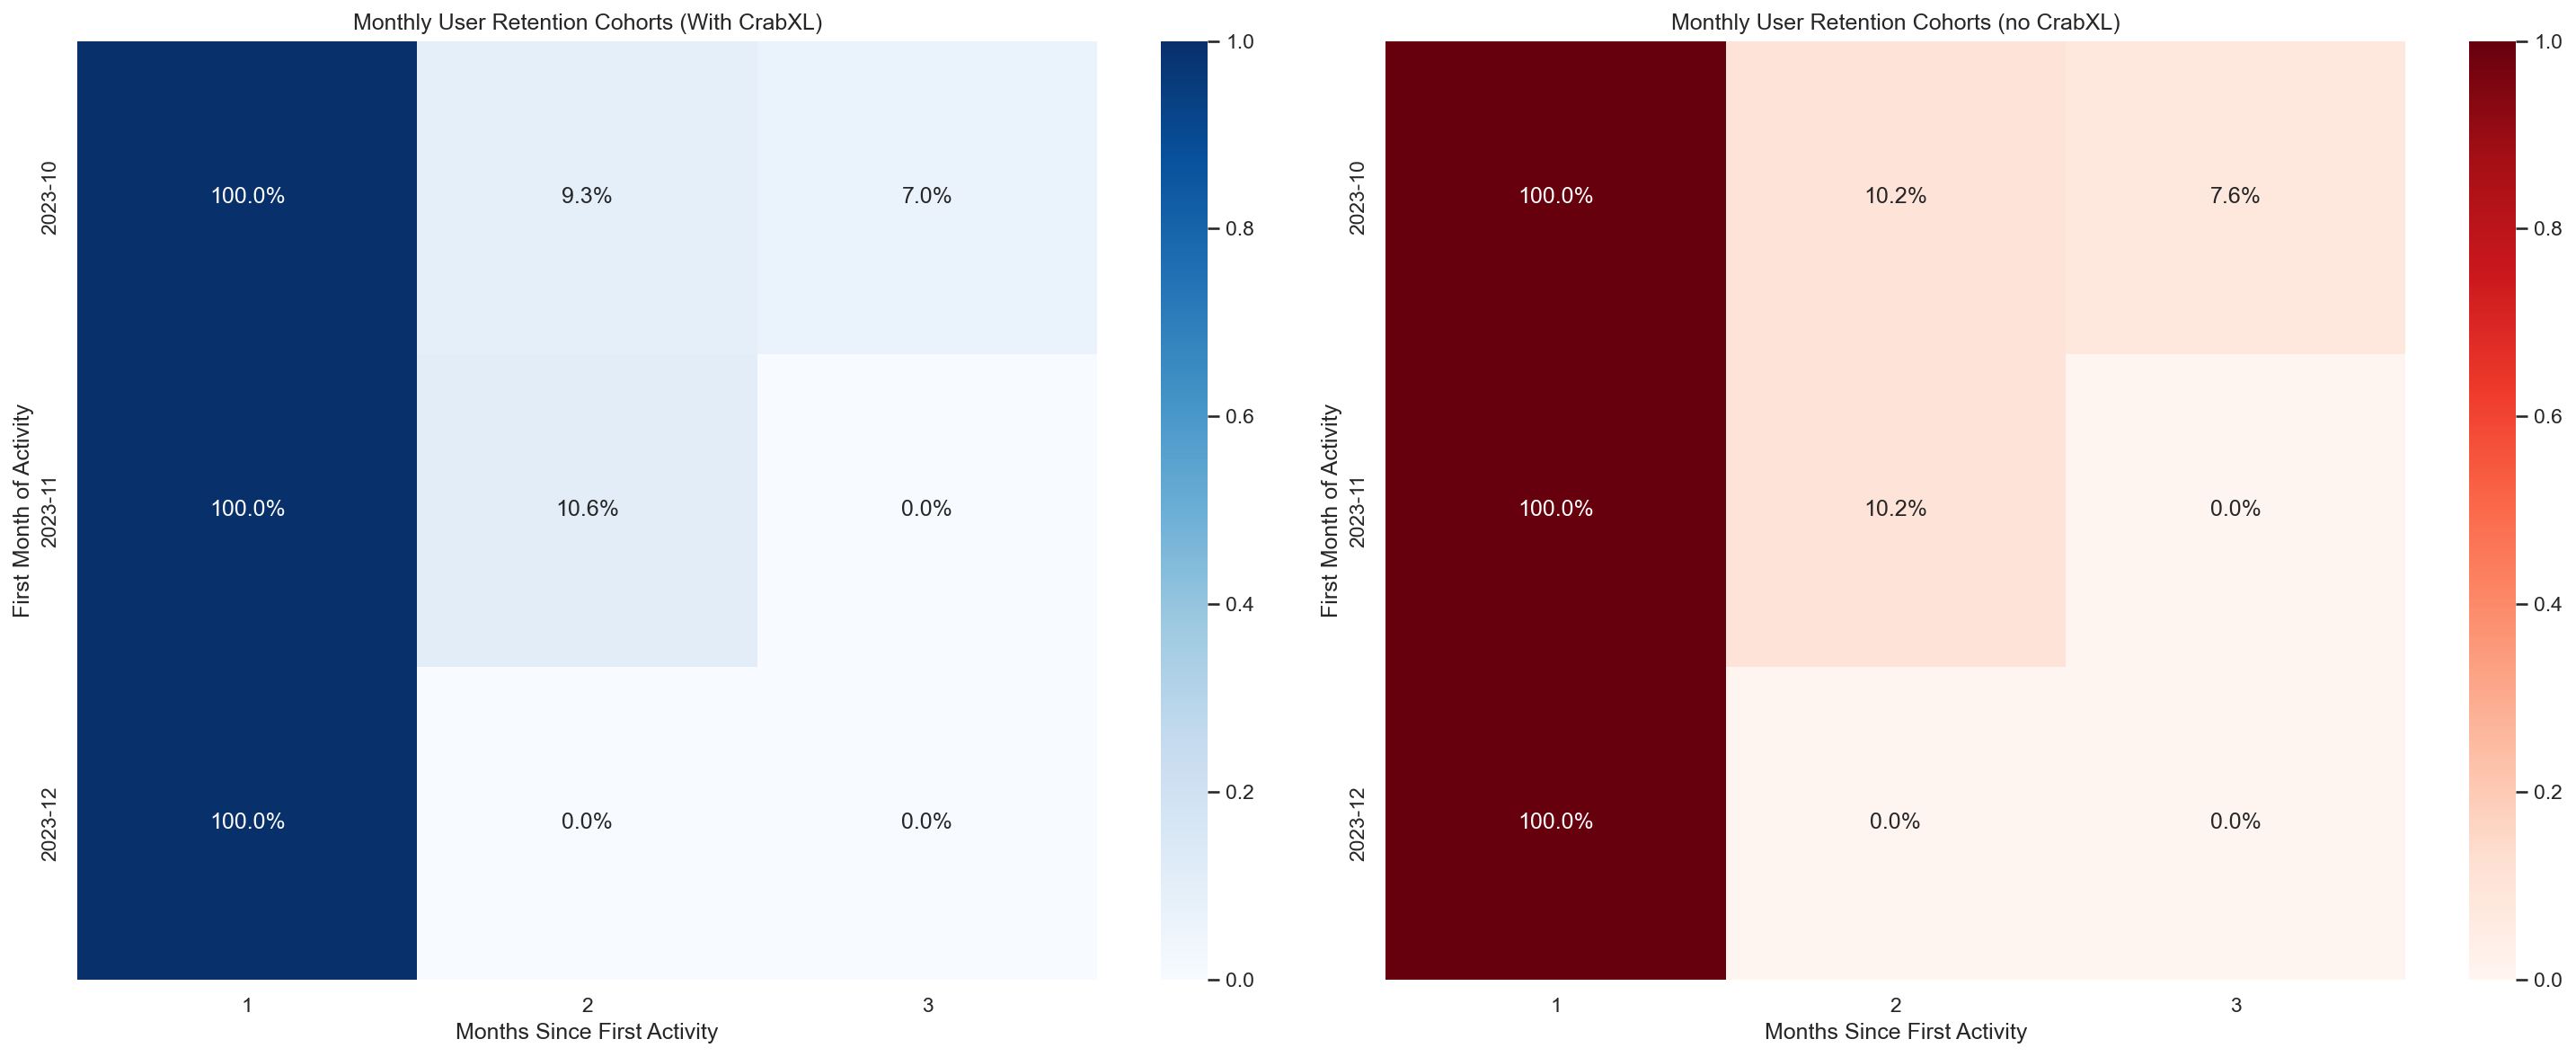

In [350]:
t_crab = retention_with_crabxl.drop(columns=['Segment'])
# t_crab = t*100
# t_crab = t.astype(int)

t_norm = retention_without_crabxl.drop(columns=['Segment'])
# t_norm = t_norm*100
# t_norm = t_norm.astype(int)


# fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# sns.heatmap(t_crab, annot=True, fmt=".0f", cmap="Blues")
# plt.title("Monthly User Retention Cohorts (With CrabXL)")
# plt.xlabel("Months Since First Activity")
# plt.ylabel("First Month of Activity")
# plt.show()
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(t_crab, annot=True, fmt=".1%", cmap="Blues", ax=ax[0])
ax[0].set_title("Monthly User Retention Cohorts (With CrabXL)")
ax[0].set_xlabel("Months Since First Activity")
ax[0].set_ylabel("First Month of Activity")

sns.heatmap(t_norm, annot=True, fmt=".1%", cmap="Reds", ax=ax[1])
ax[1].set_title("Monthly User Retention Cohorts (no CrabXL)")
ax[1].set_xlabel("Months Since First Activity")
ax[1].set_ylabel("First Month of Activity")

plt.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

Text(0.5, 1.0, 'Monthly Retention Rate Comparison')

Text(0.5, 0, 'Months Since First Activity')

Text(0, 0.5, 'Retention Rate (%)')

([<matplotlib.axis.XTick at 0x2cdaee610>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '-20%'),
  Text(0, 0.0, '0%'),
  Text(0, 0.2, '20%'),
  Text(0, 0.4000000000000001, '40%'),
  Text(0, 0.6000000000000001, '60%'),
  Text(0, 0.8, '80%'),
  Text(0, 1.0000000000000002, '100%'),
  Text(0, 1.2000000000000002, '120%')])

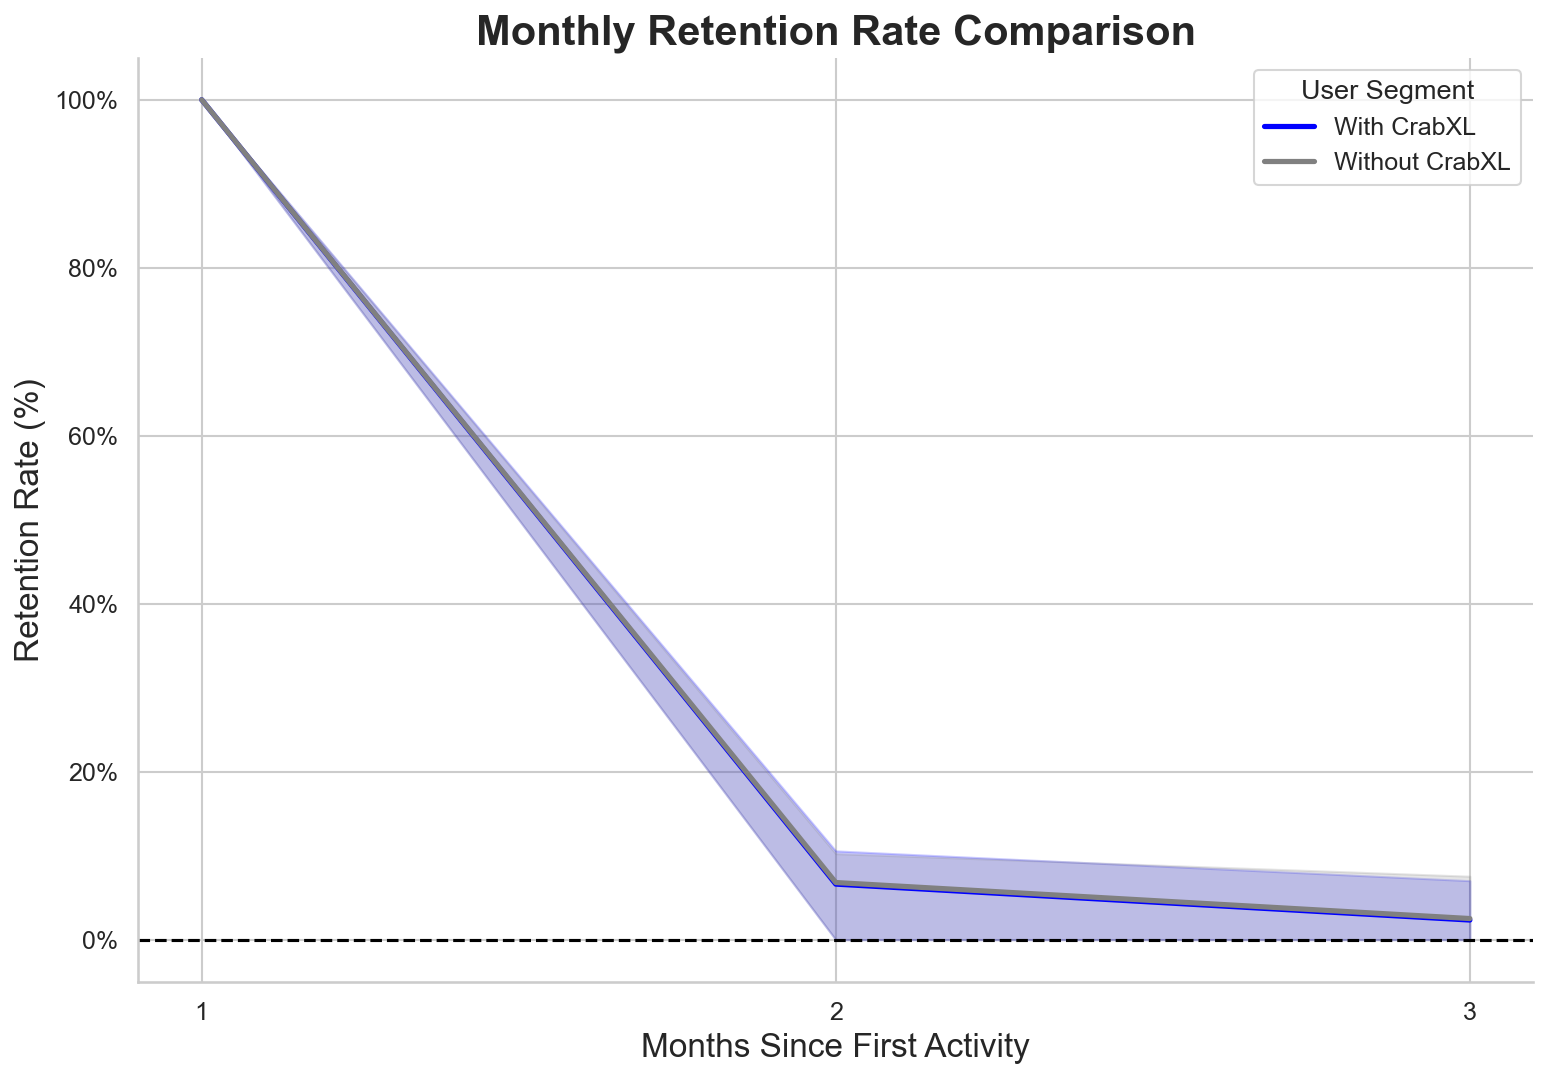

In [332]:

# Combine the data
combined_retention = pd.concat([retention_with_crabxl, retention_without_crabxl])

# Melt the data for plotting
melted_retention = combined_retention.reset_index().melt(id_vars=['FirstActivityMonth', 'Segment'], 
                                                         var_name='MonthsSinceFirstActivity', 
                                                         value_name='RetentionRate')

# Replotting with improvements: all xticks, retention rate in %, and specified colors

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Ensure all months are represented in the xticks
all_months = sorted(melted_retention['MonthsSinceFirstActivity'].unique())

# Creating the line plot with specified colors
lineplot = sns.lineplot(
    data=melted_retention, 
    x='MonthsSinceFirstActivity', 
    y='RetentionRate', 
    hue='Segment',
    palette={"With CrabXL": "blue", "Without CrabXL": "grey"},  # Specific colors
    linewidth=2.5
)

# Convert y-axis to percentage
lineplot.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# Title and labels
plt.title('Monthly Retention Rate Comparison', fontsize=20, fontweight='bold')
plt.xlabel('Months Since First Activity', fontsize=16)
plt.ylabel('Retention Rate (%)', fontsize=16)

# Legend
plt.legend(title='User Segment', title_fontsize='13', fontsize='12', loc='upper right')

# Ticks
plt.xticks(all_months, fontsize=12)
plt.yticks(fontsize=12)

# Reference line and spines
plt.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
sns.despine()

# Show the plot
plt.show()

In [333]:
# def prepare_weekly_cohort_data(df, start_date, end_date):
#     # Filtering data between October and December
#     df = df[(df['datetime'] >= pd.to_datetime(start_date)) & (df['datetime'] <= pd.to_datetime(end_date))]

#     # First activity week for each user
#     first_activity_week = df.groupby('user_id')['datetime'].min().dt.to_period('W').dt.start_time
#     df['FirstActivityWeek'] = df['user_id'].map(first_activity_week)

#     # Convert datetime to the start time of its week
#     df['datetime_week'] = df['datetime'].dt.to_period('W').dt.start_time

#     # Calculate the number of weeks since the first activity
#     df['WeekSinceFirstActivity'] = ((df['datetime_week'] - df['FirstActivityWeek']).dt.days / 7).astype(int) + 1

#     # Pivot table for cohort analysis
#     cohort_data = df.pivot_table(index='FirstActivityWeek', columns='WeekSinceFirstActivity', 
#                                  values='user_id', aggfunc='nunique', fill_value=0)

#     # Calculate retention rate
#     cohort_sizes = cohort_data.iloc[:,0]
#     retention = cohort_data.divide(cohort_sizes, axis=0)
    
#     return retention

# # Example usage
# bets_with_crabxl = bets[bets['had_CrabXL'] == 1]
# bets_without_crabxl = bets[bets['had_CrabXL'] == 0]

# # Prepare cohort data for each segment (October to December)
# retention_with_crabxl = prepare_weekly_cohort_data(bets_with_crabxl, '2022-10-01', '2022-12-31')
# retention_without_crabxl = prepare_weekly_cohort_data(bets_without_crabxl, '2022-10-01', '2022-12-31')

# # Melt the data for plotting
# melted_retention = pd.concat([retention_with_crabxl, retention_without_crabxl]).reset_index().melt(
#     id_vars=['FirstActivityWeek'], 
#     var_name='WeeksSinceFirstActivity', 
#     value_name='RetentionRate'
# )

# # Plotting
# plt.figure(figsize=(12, 8))
# sns.set(style="whitegrid")

# # Creating the line plot
# sns.lineplot(
#     data=melted_retention, 
#     x='WeeksSinceFirstActivity', 
#     y='RetentionRate', 
#     hue='FirstActivityWeek',
#     palette="tab10",
#     linewidth=2
# )

# # Convert y-axis to percentage
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# # Title and labels
# plt.title('Weekly Retention Rate Comparison: October to December', fontsize=20, fontweight='bold')
# plt.xlabel('Weeks Since First Activity', fontsize=16)
# plt.ylabel('Retention Rate (%)', fontsize=16)

# plt.xticks(rotation=45)
# plt.legend(title='First Activity Week', fontsize=12, title_fontsize='13', loc='upper right')
# plt.grid(True)
# plt.show()

# Appendix

In [ ]:

q = """
WITH BonusCrabXL_Brands AS (
    SELECT L.ENTITY_NAME,
           L.ENTITY_ID,
           R.GAME_NAME,
           L.AFFILIATE_PROGRAM,
           L.LICENSE,
           R.DATA
    FROM DWH.DIM_BRANDS L
    LEFT JOIN DWH.DIM_GAME R
                  ON L.ENTITY_IDT = R.GAME_IDT
    WHERE ENTITY_NAME IN (
                          '5gringos',
                          'rabona',
                          'sportaza',
                          'librabet',
                          'neon54',
                          'slotspalace',
                          '7signs',
                          'greatwin',
                          'casinoly',
                          'powbet',
                          'burancasino',
                          'boaboa'
        ))
SELECT *
FROM BonusCrabXL_Brands;
"""

dt = pd.read_sql(q, connection)
dt.head()

q = """
SELECT
    DISTINCT GAME_NAME 
FROM DWH.DIM_GAME;
"""
dt = pd.read_sql(q, connection)
dt.head()

In [66]:
connection = snowflake.connector.connect(
    user = snowflake_credentials['user'],
    password = snowflake_credentials['password'],
    account = snowflake_credentials['account'],
    database = snowflake_credentials['database'],
    role = snowflake_credentials['role']
    )
cursor = connection.cursor()


q = """
SELECT *
FROM DWH.DIM_BRANDS
LIMIT 3000;
"""

dim_brand = pd.read_sql(q, connection)

q = """
SELECT *
FROM DWH.DIM_GAME
LIMIT 3000;
"""
dim_game = pd.read_sql(q, connection)

q = """
SELECT *
FROM DWH.DIM_CUSTOMERS
LIMIT 1000;
"""
dim_customers = pd.read_sql(q, connection)

q = """
SELECT *
FROM DWH.DM_CUSTOMER_DAILY_ACTIVITY
LIMIT 1000;
"""
dm_customers = pd.read_sql(q, connection)

q = """
SELECT *
FROM DWH.FACT_CASINO_BETS
LIMIT 1000;
"""
fact_casino = pd.read_sql(q, connection)

dm_customers_original = pd.read_csv('../data/DWH_dbo_Fact_CustomerDailyActivity.csv')
dim_brand_original = pd.read_csv('../data/DWH_dbo_Dim_Brands.csv')
dim_game_original = pd.read_csv('../data/DWH_dbo_Dim_Game.csv')

/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/65790004.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_brand = pd.read_sql(q, connection)
/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/65790004.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_game = pd.read_sql(q, connection)
/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/65790004.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_customers = pd.read_sql(q, connection)
/var/folders/6y/p69wgs_n4cn8

In [15]:
rows = 1000
queries = {
    'DIM_CUSTOMERS': f"""
        SELECT *
        FROM DWH.DIM_CUSTOMERS
        LIMIT {rows};""",
    'DM_CUSTOMER_DAILY_ACTIVITY': f"""
        SELECT *
        FROM DWH.DM_CUSTOMER_DAILY_ACTIVITY
        LIMIT {rows};""",
    'FACT_CASINO_BETS': f"""
        SELECT *
        FROM DWH.FACT_CASINO_BETS
        LIMIT {rows}""",
    'DIM_BRANDS': f"""
        SELECT *
        FROM DWH.DIM_BRANDS
        LIMIT {rows};""",
    'DIM_GAME': f"""
        SELECT *
        FROM DWH.DIM_GAME
        LIMIT {rows};""",
}

tables = []

for table in queries.keys():
    print(f"Getting data from {table}...")
    query = queries[table]
    dt = pd.read_sql(query, connection)
    dt = dt.T
    dt = dt.add_prefix('row_')
    # dt.columns = dt.iloc[0]
    # dt = dt[1:]
    dt['table_name'] = f"DWH.{query}"
    tables.append(dt)
    print('*'*50)

tables = pd.concat(tables)
tables.to_csv('tables.csv')
tables.head()

Getting data from DIM_CUSTOMERS...


/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/3582124669.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dt = pd.read_sql(query, connection)


**************************************************
Getting data from DM_CUSTOMER_DAILY_ACTIVITY...


/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/3582124669.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dt = pd.read_sql(query, connection)


**************************************************
Getting data from FACT_CASINO_BETS...


/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/3582124669.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dt = pd.read_sql(query, connection)


**************************************************
Getting data from DIM_BRANDS...


/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/3582124669.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dt = pd.read_sql(query, connection)


**************************************************
Getting data from DIM_GAME...


/var/folders/6y/p69wgs_n4cn8pyp7ly6k1f6m0000gn/T/ipykernel_81927/3582124669.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dt = pd.read_sql(query, connection)


**************************************************


row_0      row_1      row_2      row_3      row_4      row_5  \
ACCOUNT_IDT  100000463  100000673  100000556  100000907  100000987  100001087   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40368913   40369549   40370641   40369369   40371097   40371229   
ENTITY_IDT         336        399        396        354        131        399   
TYPE            casino     casino     casino     casino     casino     casino   

                 row_6      row_7      row_8      row_9     row_10     row_11  \
ACCOUNT_IDT  100000656  100000564  100000732  100000622  100000539  100000887   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40368509   40369625   40370865   40370721   40369617   40368317   
ENTITY_IDT         329        329        343      95277      95277        390   
TYPE            casino     casino     casino     casino     casino     casino   

                row_12     row_13     row_14     row_15     row_16     row_17  \
ACCOUNT_IDT  100000518  100000979  100000225  100001083  100000478  100000249   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40367901   40370177   40368557   40368817   40370665   40368481   
ENTITY_IDT         326      95277        150        124        390        150   
TYPE            casino     casino     casino     casino     casino     casino   

                row_18     row_19     row_20     row_21     row_22     row_23  \
ACCOUNT_IDT  100000842  100000333  100000976  100000558  100000802  100000747   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40369125   40371241   40369253   40371165   40371409   40370393   
ENTITY_IDT         329        126        362        348        150        329   
TYPE            casino     casino     casino     casino     casino     casino   

                row_24     row_25     row_26     row_27     row_28     row_29  \
ACCOUNT_IDT  100000864  100000370  100000344  100000298  100001036  100000647   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40369209   40369185   40370545   40369333   40369297   40371545   
ENTITY_IDT         329        217        150        326        150        329   
TYPE            casino     casino     casino     casino     casino     casino   

                row_30     row_31     row_32     row_33     row_34     row_35  \
ACCOUNT_IDT  100000739  100000352  100000480  100000775  100000377  100001103   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40368489   40369821   40371501   40369921   40368857   40368497   
ENTITY_IDT         217        150        396        150        329      95277   
TYPE            casino     casino     casino     casino     casino     casino   

                row_36     row_37     row_38     row_39     row_40     row_41  \
ACCOUNT_IDT  100000603  100000437  100000527  100000749  100000614  100000610   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40367949   40369897   40370385   40370913   40369477   40370457   
ENTITY_IDT         326        150      95277        124        150        384   
TYPE            casino     casino     casino     casino     casino     casino   

                row_42     row_43     row_44     row_45     row_46     row_47  \
ACCOUNT_IDT  100001014  100000985  100000284  100000839  100001059  100001005   
DOMAIN               1          1          1          1          1          1   
ACCOUNT_ID    40370413   40369737   40371073   40370601   40371469   40370525   
ENTITY_IDT         399        150        150        377        150        343   
TYPE            casino     casino     casino     casino     casino     casino   

                row_48     row_49     row_50     row_51     row_52     row_53  \
ACCOUNT_IDT  100000358  100000814  10000

In [22]:
dim_game.head(1)
dim_brand.head(1)
dm_customers.head(1)
fact_casino.head(1)

GAME_IDT  DOMAIN  GAME_ID PARENT_ID  GUID   GAME_NAME  GAME_SYSTEM_IDT  \
0  309665528       1  7835445      None  None  Fish&Spins              602   

   GAME_PROVIDER_IDT                CODE         CODE_MOBILE  \
0                119  ela_fish_and_spins  ela_fish_and_spins   

        CODE_EXTERNAL CODE_MOBILE_EXTERNAL  \
0  ela_fish_and_spins   ela_fish_and_spins   

                                                DATA  ALLOW_FREESPINS  TYPE  \
0  {"bonus_no_play": false, "product_classificati...              1.0  None   

  ALIAS OPTIONS DELETED CREATED UPDATED  ACTIVE TABLES  MINBET  MAXBET  BONUS  \
0  None    None    None     NaT     NaT     NaN   None     NaN     NaN    NaN   

   LIVE  DEMO  WAGER  RETURN_TO_PLAYER VOLATILITY COUNTRIES COUNTRIES_FILTER  \
0     0   NaN    NaN               NaN       None      None             None   

  BONUS_RESTRICTED_COUNTRIES  VERSION  JACKPOT  OLD_GAME_ID  \
0                       None      NaN      NaN          NaN   

          SOURCE_TABLE            REC_INS_DATE            REC_UPD_DATE  
0  casino_api.api_game 2024-01-18 14:04:48.272 2024-01-18 17:14:49.130

ENTITY_IDT  DOMAIN  ENTITY_ID ENTITY_NAME PREFIX BUSINESS  LICENSE  \
0      467476       4        133  RobyCasino   RBC_      B2B  Curacao   

  AFFILIATE_PROGRAM  B2B_PARTNER  B2B_GROUP            HOST  IS_ACTIVE  \
0       Not defined  Not defined        NaN  robycasino.com      False   

   IS_REPORTABLE     SOURCE_TABLE            REC_INS_DATE  \
0          False  project.project 2024-01-10 14:08:33.993   

             REC_UPD_DATE  
0 2024-01-18 17:14:39.522

ACCOUNT_IDT  ACCOUNT_ID  DOMAIN REPORTING_DATE  DEPOSIT_AMOUNT_EUR  \
0      3332868    23257059       1     2023-11-11                 0.0   

  CUMULATIVE_DEPOSIT_AMOUNT_EUR  DEPOSIT_COUNT  WITHDRAW_AMOUNT_EUR  \
0                          None              0                  0.0   

   WITHDRAW_COUNT  GGR_CASINO_EUR  BONUS_GGR_CASINO_EUR  TURNOVER_CASINO_EUR  \
0               0            0.09                   0.0                 0.09   

   BONUS_TURNOVER_CASINO_EUR  CASINO_BET_COUNT  GGR_SPORT_EUR  \
0                        0.0                 1            0.0   

   BONUS_GGR_SPORT_EUR  TURNOVER_SPORT_EUR  BONUS_TURNOVER_SPORT_EUR  \
0                  0.0                 0.0                       0.0   

   SPORT_BET_COUNT  RELEASE_BONUS_EUR  CANCELLED_BONUS_EUR  \
0                0                0.0                  0.0   

   TOTAL_BONUS_GIVEN_EUR  CASH_BONUS_EUR  DEPOSIT_BONUS_EUR  \
0                    0.0             0.0                0.0   

   DEPOSIT_BONUS_SPORT_EUR  DEPOSIT_BONUS_CASINO_EUR  RELEASE_BONUS_SPORT_EUR  \
0                      0.0                       0.0                      0.0   

   RELEASE_BONUS_CASINO_EUR  CANCELLED_BONUS_CASINO_EUR  \
0                       0.0                         0.0   

   CANCELLED_BONUS_SPORT_EUR   NGR  GGR_LIVE_CASINO_EUR  \
0                        0.0  0.09                  0.0   

   BONUS_GGR_LIVE_CASINO_EUR  TURNOVER_LIVE_CASINO_EUR  \
0                        0.0                       0.0   

   BONUS_TURNOVER_LIVE_CASINO_EUR  CASINO_LIVE_BET_COUNT  \
0                             0.0                      0   

   TURNOVER_CASINO_WEB_EUR  TURNOVER_CASINO_MOBILE_EUR  DEDUCTIONS  \
0                     0.09                         0.0         0.0   

             REC_INS_DATE            REC_UPD_DATE  
0 2024-01-17 08:30:24.201 2024-01-17 08:30:24.201

ACCOUNT_IDT  ACCOUNT_ID  DOMAIN       DATE PLATFORM  GAME_IDT CURRENCY  \
0      4363298    14091430       1 2022-01-25    phone       481      EUR   

   GGR_USER_CURRENCY  TURNOVER_USER_CURRENCY  GGR_EUR  TURNOVER_EUR  \
0                0.0                     0.0      0.0           0.0   

   BONUS_GGR_USER_CURRENCY  BONUS_TURNOVER_USER_CURRENCY  BONUS_GGR_EUR  \
0                    -0.15                         37.75          -0.15   

   BONUS_TURNOVER_EUR  CASINO_BET_COUNT  ROLLBACKS  BONUS_ROLLBACK  BET_TAX  \
0               37.75               171        0.0             0.0      0.0   

   ROLLBACKS_EUR  BONUS_ROLLBACK_EUR GAME_SESSION_COUNT  \
0            0.0                 0.0               None   

  GAME_SES_COUNT_WITH_REASON IS_LIVE SOURCE_TABLE            REC_INS_DATE  \
0                       None    None   FIRST_LOAD 2023-11-27 13:34:37.206   

             REC_UPD_DATE  
0 2023-11-27 13:34:37.206

In [56]:
# Convert all column names to lower case and remove underscores
dbo_columns_processed = [col.lower().replace('_', '') for col in dbo_columns]
snowflake_columns_processed = [col.lower().replace('_', '') for col in snowflake_columns]

# Create dictionaries to map original column names to processed column names
dbo_columns_mapping = {col: col.lower().replace('_', '') for col in dbo_columns}
snowflake_columns_mapping = {col: col.lower().replace('_', '') for col in snowflake_columns}

# Create a dictionary to map processed dbo_columns to processed snowflake_columns
processed_column_mapping = {}

# Iterate over dbo_columns_mapping
for dbo_col, dbo_col_processed in dbo_columns_mapping.items():
    # Find the matching column in snowflake_columns_mapping
    for snowflake_col, snowflake_col_processed in snowflake_columns_mapping.items():
        if dbo_col_processed == snowflake_col_processed:
            # Add the mapping to the dictionary
            processed_column_mapping[dbo_col] = snowflake_col
            break

# Function to generate SQL query
def generate_sql_query(table_name, column_mapping):
    # Start the SELECT statement
    query = "SELECT\n"

    # Add columns to the query
    for dbo_col, snowflake_col in column_mapping.items():
        query += f"    {snowflake_col} AS {dbo_col},\n"

    # Remove the last comma and newline
    query = query.rstrip(',\n')

    # Add the FROM clause
    query += f"\nFROM\n    {table_name};"

    return query

# Usage:
table_name = 'DWH.DM_CUSTOMER_DAILY_ACTIVITY'
print(generate_sql_query(table_name, processed_column_mapping))

SELECT
    ACCOUNT_ID AS account_id,
    DOMAIN AS domain,
    REPORTING_DATE AS ReportingDate,
    DEPOSIT_AMOUNT_EUR AS DepositAmount_EUR,
    DEPOSIT_COUNT AS DepositCount,
    WITHDRAW_AMOUNT_EUR AS WithdrawAmount_EUR,
    WITHDRAW_COUNT AS WithdrawCount,
    GGR_CASINO_EUR AS GGRCasino_EUR,
    BONUS_GGR_CASINO_EUR AS bonus_GGRCasino_EUR,
    TURNOVER_CASINO_EUR AS TurnoverCasino_EUR,
    BONUS_TURNOVER_CASINO_EUR AS bonus_TurnoverCasino_EUR,
    TURNOVER_CASINO_MOBILE_EUR AS TurnoverCasino_Mobile_EUR,
    TURNOVER_CASINO_WEB_EUR AS TurnoverCasino_Web_EUR,
    CASINO_BET_COUNT AS casino_bet_count,
    GGR_SPORT_EUR AS GGRSport_EUR,
    BONUS_GGR_SPORT_EUR AS bonus_GGRSport_EUR,
    TURNOVER_SPORT_EUR AS TurnoverSport_EUR,
    BONUS_TURNOVER_SPORT_EUR AS bonus_TurnoverSport_EUR,
    SPORT_BET_COUNT AS sport_bet_count,
    CANCELLED_BONUS_EUR AS CancelledBonus_EUR,
    TOTAL_BONUS_GIVEN_EUR AS TotalBonusGiven_EUR,
    CASH_BONUS_EUR AS CashBonus_EUR,
    DEPOSIT_BONUS_EUR AS Deposit

In [60]:
def generate_agg_sql(table_name, columns, dimensions, remove_columns=[], agg_function='SUM'):
    # Start the SELECT statement
    query = "SELECT\n"

    # Add dimensions to the query
    for dimension in dimensions:
        if dimension not in remove_columns:
            query += f"    {dimension},\n"

    # Add aggregated columns to the query
    for column in columns:
        if column not in dimensions and column not in remove_columns:
            query += f"    {agg_function}({column}) AS {column},\n"

    # Remove the last comma and newline
    query = query.rstrip(',\n')

    # Add the FROM clause
    query += f"\nFROM\n    {table_name}"

    # Add the GROUP BY clause
    query += "\nGROUP BY\n    " + ',\n    '.join([dim for dim in dimensions if dim not in remove_columns]) + ';'

    return query

# Usage:
columns = dm_customers.columns.tolist()
dimensions = ['ACCOUNT_IDT', 'ACCOUNT_ID', 'DOMAIN', 'REPORTING_DATE']
remove_columns = ['REC_INS_DATE','REC_UPD_DATE']
table_name = 'DWH.DM_CUSTOMER_DAILY_ACTIVITY'
print(generate_agg_sql(table_name, columns, dimensions, remove_columns))

SELECT
    ACCOUNT_IDT,
    ACCOUNT_ID,
    DOMAIN,
    REPORTING_DATE,
    SUM(DEPOSIT_AMOUNT_EUR) AS DEPOSIT_AMOUNT_EUR,
    SUM(CUMULATIVE_DEPOSIT_AMOUNT_EUR) AS CUMULATIVE_DEPOSIT_AMOUNT_EUR,
    SUM(DEPOSIT_COUNT) AS DEPOSIT_COUNT,
    SUM(WITHDRAW_AMOUNT_EUR) AS WITHDRAW_AMOUNT_EUR,
    SUM(WITHDRAW_COUNT) AS WITHDRAW_COUNT,
    SUM(GGR_CASINO_EUR) AS GGR_CASINO_EUR,
    SUM(BONUS_GGR_CASINO_EUR) AS BONUS_GGR_CASINO_EUR,
    SUM(TURNOVER_CASINO_EUR) AS TURNOVER_CASINO_EUR,
    SUM(BONUS_TURNOVER_CASINO_EUR) AS BONUS_TURNOVER_CASINO_EUR,
    SUM(CASINO_BET_COUNT) AS CASINO_BET_COUNT,
    SUM(GGR_SPORT_EUR) AS GGR_SPORT_EUR,
    SUM(BONUS_GGR_SPORT_EUR) AS BONUS_GGR_SPORT_EUR,
    SUM(TURNOVER_SPORT_EUR) AS TURNOVER_SPORT_EUR,
    SUM(BONUS_TURNOVER_SPORT_EUR) AS BONUS_TURNOVER_SPORT_EUR,
    SUM(SPORT_BET_COUNT) AS SPORT_BET_COUNT,
    SUM(RELEASE_BONUS_EUR) AS RELEASE_BONUS_EUR,
    SUM(CANCELLED_BONUS_EUR) AS CANCELLED_BONUS_EUR,
    SUM(TOTAL_BONUS_GIVEN_EUR) AS TOTAL_BONUS_GIV

In [61]:
# columns = dm_customers.columns.tolist()
# query = "SELECT "

# for col in columns:
#     if col not in ['ACCOUNT_IDT', 'ACCOUNT_ID', 'DOMAIN', 'REPORTING_DATE']:  # Exclude non-numeric columns
#         query += f"SUM({col}), "

# query = query.rstrip(', ')  # Remove trailing comma and space
# query += " FROM your_table_name GROUP BY ACCOUNT_IDT, ACCOUNT_ID, DOMAIN, REPORTING_DATE;"

# print(query)

In [26]:
SELECT 
    ACCOUNT_IDT,
    ACCOUNT_ID,
    DOMAIN,
    REPORTING_DATE,
    SUM(DEPOSIT_AMOUNT_EUR), 
    SUM(CUMULATIVE_DEPOSIT_AMOUNT_EUR), 
    SUM(DEPOSIT_COUNT), 
    SUM(WITHDRAW_AMOUNT_EUR), 
    SUM(WITHDRAW_COUNT), 
    SUM(GGR_CASINO_EUR), 
    SUM(BONUS_GGR_CASINO_EUR), 
    SUM(TURNOVER_CASINO_EUR), 
    SUM(BONUS_TURNOVER_CASINO_EUR), 
    SUM(CASINO_BET_COUNT), 
    SUM(GGR_SPORT_EUR), 
    SUM(BONUS_GGR_SPORT_EUR), 
    SUM(TURNOVER_SPORT_EUR), 
    SUM(BONUS_TURNOVER_SPORT_EUR), 
    SUM(SPORT_BET_COUNT), 
    SUM(RELEASE_BONUS_EUR), 
    SUM(CANCELLED_BONUS_EUR), 
    SUM(TOTAL_BONUS_GIVEN_EUR), 
    SUM(CASH_BONUS_EUR), 
    SUM(DEPOSIT_BONUS_EUR), 
    SUM(DEPOSIT_BONUS_SPORT_EUR), 
    SUM(DEPOSIT_BONUS_CASINO_EUR), 
    SUM(RELEASE_BONUS_SPORT_EUR), 
    SUM(RELEASE_BONUS_CASINO_EUR), 
    SUM(CANCELLED_BONUS_CASINO_EUR), 
    SUM(CANCELLED_BONUS_SPORT_EUR), 
    SUM(NGR), 
    SUM(GGR_LIVE_CASINO_EUR), 
    SUM(BONUS_GGR_LIVE_CASINO_EUR), 
    SUM(TURNOVER_LIVE_CASINO_EUR), 
    SUM(BONUS_TURNOVER_LIVE_CASINO_EUR), 
    SUM(CASINO_LIVE_BET_COUNT), 
    SUM(TURNOVER_CASINO_WEB_EUR), 
    SUM(TURNOVER_CASINO_MOBILE_EUR), 
    SUM(DEDUCTIONS), 
    SUM(REC_INS_DATE), 
    SUM(REC_UPD_DATE) 
FROM 
    your_table_name 
GROUP BY 
    ACCOUNT_IDT, 
    ACCOUNT_ID, 
    DOMAIN, 
    REPORTING_DATE;

'SELECT SUM(DEPOSIT_AMOUNT_EUR), SUM(CUMULATIVE_DEPOSIT_AMOUNT_EUR), SUM(DEPOSIT_COUNT), SUM(WITHDRAW_AMOUNT_EUR), SUM(WITHDRAW_COUNT), SUM(GGR_CASINO_EUR), SUM(BONUS_GGR_CASINO_EUR), SUM(TURNOVER_CASINO_EUR), SUM(BONUS_TURNOVER_CASINO_EUR), SUM(CASINO_BET_COUNT), SUM(GGR_SPORT_EUR), SUM(BONUS_GGR_SPORT_EUR), SUM(TURNOVER_SPORT_EUR), SUM(BONUS_TURNOVER_SPORT_EUR), SUM(SPORT_BET_COUNT), SUM(RELEASE_BONUS_EUR), SUM(CANCELLED_BONUS_EUR), SUM(TOTAL_BONUS_GIVEN_EUR), SUM(CASH_BONUS_EUR), SUM(DEPOSIT_BONUS_EUR), SUM(DEPOSIT_BONUS_SPORT_EUR), SUM(DEPOSIT_BONUS_CASINO_EUR), SUM(RELEASE_BONUS_SPORT_EUR), SUM(RELEASE_BONUS_CASINO_EUR), SUM(CANCELLED_BONUS_CASINO_EUR), SUM(CANCELLED_BONUS_SPORT_EUR), SUM(NGR), SUM(GGR_LIVE_CASINO_EUR), SUM(BONUS_GGR_LIVE_CASINO_EUR), SUM(TURNOVER_LIVE_CASINO_EUR), SUM(BONUS_TURNOVER_LIVE_CASINO_EUR), SUM(CASINO_LIVE_BET_COUNT), SUM(TURNOVER_CASINO_WEB_EUR), SUM(TURNOVER_CASINO_MOBILE_EUR), SUM(DEDUCTIONS), SUM(REC_INS_DATE), SUM(REC_UPD_DATE) FROM your_table_name

In [47]:
# Convert all column names to lower case and remove underscores
dbo_columns_processed = [col.lower().replace('_', '') for col in dbo_columns]
snowflake_columns_processed = [col.lower().replace('_', '') for col in snowflake_columns]


# Create a dictionary to map dbo_columns to snowflake_columns
column_mapping = {}

# Iterate over dbo_columns_processed
for dbo_col in dbo_columns_processed:
    # Find the matching column in snowflake_columns_processed
    for snowflake_col, original_snowflake_col in zip(snowflake_columns_processed, snowflake_columns):
        if dbo_col == snowflake_col:
            # Add the mapping to the dictionary
            column_mapping[dbo_col] = original_snowflake_col
            break

print(column_mapping)

{'accountid': 'ACCOUNT_ID', 'domain': 'DOMAIN', 'reportingdate': 'REPORTING_DATE', 'depositamounteur': 'DEPOSIT_AMOUNT_EUR', 'depositcount': 'DEPOSIT_COUNT'}


In [52]:
# Create dictionaries to map original column names to processed column names
dbo_columns = dm_customers_original.columns.tolist()
snowflake_columns = dm_customers.columns.tolist()

dbo_columns_mapping = {col: col.lower().replace('_', '') for col in dbo_columns}
snowflake_columns_mapping = {col: col.lower().replace('_', '') for col in snowflake_columns}

print(dbo_columns_mapping)
print(snowflake_columns_mapping)

{'account_id': 'accountid', 'domain': 'domain', 'ReportingDate': 'reportingdate', 'DepositAmount_EUR': 'depositamounteur', 'DepositCount': 'depositcount', 'WithdrawAmount_EUR': 'withdrawamounteur', 'WithdrawCount': 'withdrawcount', 'GGRCasino_EUR': 'ggrcasinoeur', 'bonus_GGRCasino_EUR': 'bonusggrcasinoeur', 'GGRCasino_Mobile_EUR': 'ggrcasinomobileeur', 'GGRCasino_Web_EUR': 'ggrcasinowebeur', 'TurnoverCasino_EUR': 'turnovercasinoeur', 'bonus_TurnoverCasino_EUR': 'bonusturnovercasinoeur', 'TurnoverCasino_Mobile_EUR': 'turnovercasinomobileeur', 'TurnoverCasino_Web_EUR': 'turnovercasinowebeur', 'casino_bet_count': 'casinobetcount', 'GGRSport_EUR': 'ggrsporteur', 'bonus_GGRSport_EUR': 'bonusggrsporteur', 'TurnoverSport_EUR': 'turnoversporteur', 'bonus_TurnoverSport_EUR': 'bonusturnoversporteur', 'sport_bet_count': 'sportbetcount', 'AwardedBonus_EUR': 'awardedbonuseur', 'CancelledBonus_EUR': 'cancelledbonuseur', 'TotalBonusGiven_EUR': 'totalbonusgiveneur', 'CashBonus_EUR': 'cashbonuseur', 'D

In [53]:
# Create a dictionary to map processed dbo_columns to processed snowflake_columns
processed_column_mapping = {}

# Iterate over dbo_columns_mapping
for dbo_col, dbo_col_processed in dbo_columns_mapping.items():
    # Find the matching column in snowflake_columns_mapping
    for snowflake_col, snowflake_col_processed in snowflake_columns_mapping.items():
        if dbo_col_processed == snowflake_col_processed:
            # Add the mapping to the dictionary
            processed_column_mapping[dbo_col] = snowflake_col
            break

print(processed_column_mapping)

{'account_id': 'ACCOUNT_ID', 'domain': 'DOMAIN', 'ReportingDate': 'REPORTING_DATE', 'DepositAmount_EUR': 'DEPOSIT_AMOUNT_EUR', 'DepositCount': 'DEPOSIT_COUNT', 'WithdrawAmount_EUR': 'WITHDRAW_AMOUNT_EUR', 'WithdrawCount': 'WITHDRAW_COUNT', 'GGRCasino_EUR': 'GGR_CASINO_EUR', 'bonus_GGRCasino_EUR': 'BONUS_GGR_CASINO_EUR', 'TurnoverCasino_EUR': 'TURNOVER_CASINO_EUR', 'bonus_TurnoverCasino_EUR': 'BONUS_TURNOVER_CASINO_EUR', 'TurnoverCasino_Mobile_EUR': 'TURNOVER_CASINO_MOBILE_EUR', 'TurnoverCasino_Web_EUR': 'TURNOVER_CASINO_WEB_EUR', 'casino_bet_count': 'CASINO_BET_COUNT', 'GGRSport_EUR': 'GGR_SPORT_EUR', 'bonus_GGRSport_EUR': 'BONUS_GGR_SPORT_EUR', 'TurnoverSport_EUR': 'TURNOVER_SPORT_EUR', 'bonus_TurnoverSport_EUR': 'BONUS_TURNOVER_SPORT_EUR', 'sport_bet_count': 'SPORT_BET_COUNT', 'CancelledBonus_EUR': 'CANCELLED_BONUS_EUR', 'TotalBonusGiven_EUR': 'TOTAL_BONUS_GIVEN_EUR', 'CashBonus_EUR': 'CASH_BONUS_EUR', 'DepositBonus_EUR': 'DEPOSIT_BONUS_EUR', 'DepositBonusSport_EUR': 'DEPOSIT_BONUS_S

In [54]:
processed_column_mapping

{'account_id': 'ACCOUNT_ID',
 'domain': 'DOMAIN',
 'ReportingDate': 'REPORTING_DATE',
 'DepositAmount_EUR': 'DEPOSIT_AMOUNT_EUR',
 'DepositCount': 'DEPOSIT_COUNT',
 'WithdrawAmount_EUR': 'WITHDRAW_AMOUNT_EUR',
 'WithdrawCount': 'WITHDRAW_COUNT',
 'GGRCasino_EUR': 'GGR_CASINO_EUR',
 'bonus_GGRCasino_EUR': 'BONUS_GGR_CASINO_EUR',
 'TurnoverCasino_EUR': 'TURNOVER_CASINO_EUR',
 'bonus_TurnoverCasino_EUR': 'BONUS_TURNOVER_CASINO_EUR',
 'TurnoverCasino_Mobile_EUR': 'TURNOVER_CASINO_MOBILE_EUR',
 'TurnoverCasino_Web_EUR': 'TURNOVER_CASINO_WEB_EUR',
 'casino_bet_count': 'CASINO_BET_COUNT',
 'GGRSport_EUR': 'GGR_SPORT_EUR',
 'bonus_GGRSport_EUR': 'BONUS_GGR_SPORT_EUR',
 'TurnoverSport_EUR': 'TURNOVER_SPORT_EUR',
 'bonus_TurnoverSport_EUR': 'BONUS_TURNOVER_SPORT_EUR',
 'sport_bet_count': 'SPORT_BET_COUNT',
 'CancelledBonus_EUR': 'CANCELLED_BONUS_EUR',
 'TotalBonusGiven_EUR': 'TOTAL_BONUS_GIVEN_EUR',
 'CashBonus_EUR': 'CASH_BONUS_EUR',
 'DepositBonus_EUR': 'DEPOSIT_BONUS_EUR',
 'DepositBonusSport

In [55]:
def generate_sql_query(table_name, column_mapping):
    # Start the SELECT statement
    query = "SELECT\n"

    # Add columns to the query
    for dbo_col, snowflake_col in column_mapping.items():
        query += f"    {snowflake_col} AS {dbo_col},\n"

    # Remove the last comma and newline
    query = query.rstrip(',\n')

    # Add the FROM clause
    query += f"\nFROM\n    {table_name};"

    return query

# Usage:
table_name = 'your_table_name'
print(generate_sql_query(table_name, processed_column_mapping))

SELECT
    ACCOUNT_ID AS account_id,
    DOMAIN AS domain,
    REPORTING_DATE AS ReportingDate,
    DEPOSIT_AMOUNT_EUR AS DepositAmount_EUR,
    DEPOSIT_COUNT AS DepositCount,
    WITHDRAW_AMOUNT_EUR AS WithdrawAmount_EUR,
    WITHDRAW_COUNT AS WithdrawCount,
    GGR_CASINO_EUR AS GGRCasino_EUR,
    BONUS_GGR_CASINO_EUR AS bonus_GGRCasino_EUR,
    TURNOVER_CASINO_EUR AS TurnoverCasino_EUR,
    BONUS_TURNOVER_CASINO_EUR AS bonus_TurnoverCasino_EUR,
    TURNOVER_CASINO_MOBILE_EUR AS TurnoverCasino_Mobile_EUR,
    TURNOVER_CASINO_WEB_EUR AS TurnoverCasino_Web_EUR,
    CASINO_BET_COUNT AS casino_bet_count,
    GGR_SPORT_EUR AS GGRSport_EUR,
    BONUS_GGR_SPORT_EUR AS bonus_GGRSport_EUR,
    TURNOVER_SPORT_EUR AS TurnoverSport_EUR,
    BONUS_TURNOVER_SPORT_EUR AS bonus_TurnoverSport_EUR,
    SPORT_BET_COUNT AS sport_bet_count,
    CANCELLED_BONUS_EUR AS CancelledBonus_EUR,
    TOTAL_BONUS_GIVEN_EUR AS TotalBonusGiven_EUR,
    CASH_BONUS_EUR AS CashBonus_EUR,
    DEPOSIT_BONUS_EUR AS Deposit

In [51]:
processed_column_mapping

{'account_id': 'ACCOUNT_ID',
 'domain': 'DOMAIN',
 'ReportingDate': 'REPORTING_DATE',
 'DepositAmount_EUR': 'DEPOSIT_AMOUNT_EUR',
 'DepositCount': 'DEPOSIT_COUNT'}

In [48]:
def map_dbo_to_snowflake(dbo_columns, column_mapping):
    # Map each column name in dbo_columns to its corresponding name in snowflake_columns
    snowflake_columns = [column_mapping.get(col, col) for col in dbo_columns]
    return snowflake_columns

# Usage:
dbo_columns = dbo_columns
mapped_snowflake_columns = map_dbo_to_snowflake(dbo_columns, column_mapping)

# Print the mapping
for dbo_col, snowflake_col in zip(dbo_columns, mapped_snowflake_columns):
    print(f"{dbo_col}: {snowflake_col}")

account_id: account_id
domain: DOMAIN
ReportingDate: ReportingDate
DepositAmount_EUR: DepositAmount_EUR
DepositCount: DepositCount


In [40]:
# Create a dictionary to map snowflake_columns to dbo_columns
column_mapping_reverse = {}

# Iterate over snowflake_columns_processed
for snowflake_col in snowflake_columns_processed:
    # Find the matching column in dbo_columns_processed
    for dbo_col, original_dbo_col in zip(dbo_columns_processed, dbo_columns):
        if snowflake_col == dbo_col:
            # Add the mapping to the dictionary
            column_mapping_reverse[snowflake_col] = original_dbo_col
            break

column_mapping_reverse

{'accountid': 'account_id',
 'domain': 'domain',
 'reportingdate': 'ReportingDate',
 'depositamounteur': 'DepositAmount_EUR',
 'depositcount': 'DepositCount',
 'withdrawamounteur': 'WithdrawAmount_EUR',
 'withdrawcount': 'WithdrawCount',
 'ggrcasinoeur': 'GGRCasino_EUR',
 'bonusggrcasinoeur': 'bonus_GGRCasino_EUR',
 'turnovercasinoeur': 'TurnoverCasino_EUR',
 'bonusturnovercasinoeur': 'bonus_TurnoverCasino_EUR',
 'casinobetcount': 'casino_bet_count',
 'ggrsporteur': 'GGRSport_EUR',
 'bonusggrsporteur': 'bonus_GGRSport_EUR',
 'turnoversporteur': 'TurnoverSport_EUR',
 'bonusturnoversporteur': 'bonus_TurnoverSport_EUR',
 'sportbetcount': 'sport_bet_count',
 'cancelledbonuseur': 'CancelledBonus_EUR',
 'totalbonusgiveneur': 'TotalBonusGiven_EUR',
 'cashbonuseur': 'CashBonus_EUR',
 'depositbonuseur': 'DepositBonus_EUR',
 'depositbonussporteur': 'DepositBonusSport_EUR',
 'depositbonuscasinoeur': 'DepositBonusCasino_EUR',
 'cancelledbonuscasinoeur': 'CancelledBonusCasino_EUR',
 'cancelledbonus

In [ ]:
q = """
SELECT
    C.BR,
    BR.License,
    BR.affiliate_program,
    C.domain,
    C.country,
    C.country_name,
    CASE WHEN C.traffic = 'affiliate' THEN 'affiliate' ELSE 'media' END AS traffic,
    LAST_DAY(CC.ReportingDate) AS mm,
    SUM(CC.DepositAmount_EUR) AS deposit,
    COUNT(DISTINCT CASE WHEN CC.DepositCount > 0 THEN CC.account_id ELSE NULL END) AS depositors,
    SUM(CASE WHEN EOMONTH(C.first_deposit_date) = EOMONTH(CC.ReportingDate) THEN CC.DepositAmount_EUR ELSE 0 END) AS deposit_FTD,
    SUM(CC.WithdrawAmount_EUR) AS withdraw,
    SUM(CASE WHEN EOMONTH(C.first_deposit_date) = EOMONTH(CC.ReportingDate) THEN CC.WithdrawAmount_EUR ELSE 0 END) AS withdraw_FTD,
    COUNT(DISTINCT CASE WHEN CC.TurnoverCasino_EUR + CC.TurnoverSport_EUR > 0 THEN CC.account_id ELSE NULL END) AS Actives,
    COUNT(DISTINCT CASE WHEN CC.TurnoverSport_EUR > 0 THEN CC.account_id ELSE NULL END) AS Actives_sport,
    SUM(CC.GGRCasino_EUR) AS GGRCasino_EUR,
    SUM(CC.GGRSport_EUR) AS GGRSport_EUR,
    SUM(CC.DepositCount) AS DepositCount,
    SUM(CC.NGR) AS NGR,
    SUM(CASE WHEN EOMONTH(C.first_deposit_date) = EOMONTH(CC.ReportingDate) THEN CC.NGR ELSE 0 END) AS NGR_FTD,
    SUM(CC.TurnoverCasino_EUR + CC.TurnoverSport_EUR) AS TO_Casino,
    SUM(CC.TurnoverSport_EUR) AS TO_Sport
FROM
    DWH.DM_CUSTOMER_DAILY_ACTIVITY CC
JOIN
    DWH.DIM_CUSTOMERS C ON C.account_id = CC.account_id AND CC.domain = C.domain
JOIN
    DWH.DIM_BRANDS BR ON BR.entity_id = C.entity_id AND BR.domain = C.domain
WHERE
    C.type IN ('casino', 'sport') -- Adjust the date range and other conditions as required
GROUP BY
    C.brand,
    BR.License,
    BR.affiliate_program,
    C.domain,
    C.country,
    C.country_name,
    CASE WHEN C.traffic = 'affiliate' THEN 'affiliate' ELSE 'media' END,
    LAST_DAY(CC.ReportingDate)
"""

In [11]:
# dt[dt['GAME_NAME'].str.contains('Crab')]